In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy') # Values of K(t,x)
Q_real = np.load('./Q_15minutes.npy') # Input Matrix of Model
f_real = Q_real[:,1] # Inflow Rate
v_real = Q_real[:,3] # Average Speed
pi_real = np.load('./pitilde_15minutes.npy') # Values of pi(t,x)

In [3]:
pi_real.shape

(150, 2016)

Text(0, 0.5, 'Remaining Trip Distance (miles)')

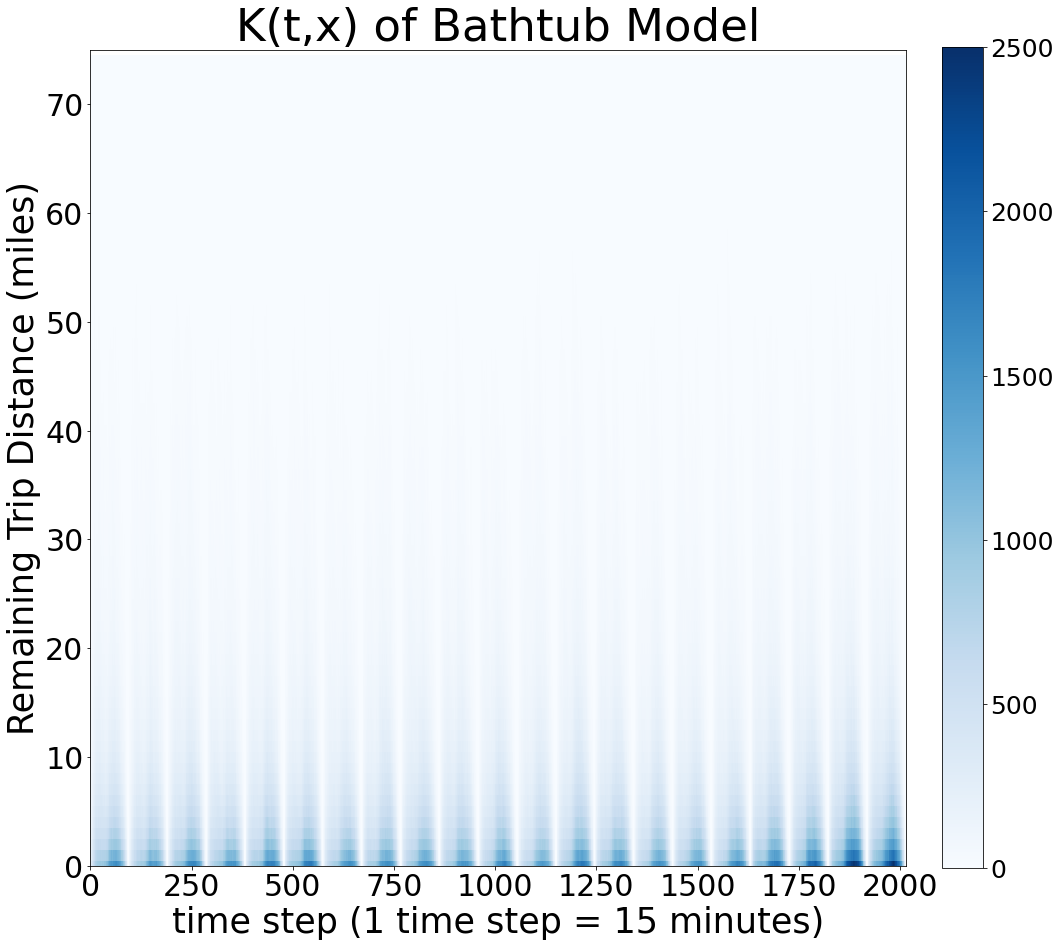

In [4]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [5]:
## Scale
N_timestep = 24*21*4 # 24 hours * 21 days * 15 minutes = total timestep
N_diststep = 75 # 1 distance step = 1 mile
Size_diststep = 1 # unit: miles
N_trainingdays = 0 # Set zero (0)
N_training = 24*4*N_trainingdays # Training data is all


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]   # x: step of remaining distance
t = np.arange(0,N_timestep)[:,None]    # Time step 
usol = K_real.transpose() [:,N_training:]     # real value of K(t,x) ==> Target Variable
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  2015
usol max =  2500


In [6]:
Size_diststep = 5 # unit: miles
Size_timestep = 2 # 2: 30min, 3: 60min
size_input = int(N_diststep/Size_diststep)*int(N_timestep/Size_timestep) # Total number of grid points
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) # Total number of data points for 'u' ==> Training data from grid points
N_f = N_u*2 #Total number of collocation (auxiliary) points 
alpha = 0.5 # weights of loss

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  15120
N_u =  3024
N_f =  6048


In [7]:
# # Previous version (before Aug 30)
# size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# # size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
# N_u = int(size_input*0.5) #Total number of data points for 'u'
# N_f = N_u*2 #Total number of collocation points 
# alpha = 0.5

# print('size input = ', size_input)
# print('N_u = ', N_u)
# print('N_f = ', N_f)

# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [8]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

# *Training Data* (All domain)


The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [9]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T[range(0,N_diststep,Size_diststep)][:,range(0,N_timestep,Size_timestep)].flatten()[:,None],T.T[range(0,N_diststep,Size_diststep)][:,range(0,N_timestep,Size_timestep)].flatten()[:,None]))
    all_u_train = usol[range(0,N_diststep,Size_diststep)][:,range(0,N_timestep,Size_timestep)].flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1234)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) # ID of training data
    test_idx = np.delete(np.arange(size_input), train_idx) # ID of testing data
    
    # Training Data
    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    # Testing Data
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [10]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [11]:
X_u_train.shape

(3024, 2)

In [12]:
X_u_test.shape

(12096, 2)

In [13]:
X_u_train

array([[0.47297297, 0.86054591],
       [0.33783784, 0.00794045],
       [0.67567568, 0.41389578],
       ...,
       [0.40540541, 0.96277916],
       [0.74324324, 0.81191067],
       [0.81081081, 0.03970223]])

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [14]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u
    
    def loss(self,x,y):

        loss_u = self.loss_BC(x,y)

        loss = loss_u

        return loss, loss_u
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u= self.loss(X_u_train, u_train)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u = self.loss(X_u_train, u_train)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        
        tf.print(loss_value, loss_u, error_vec)

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [15]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
#                                             'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 15000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.012344528482128034 0.012344528482128034 0.8356909242270608
0.010963275891421093 0.010963275891421093 0.7900567683044063
0.010126577741115812 0.010126577741115812 0.7610121520307078
0.010059073170413955 0.010059073170413955 0.7578697541155428
0.0099615767008431489 0.0099615767008431489 0.7528690785441692
0.0098915162140528652 0.0098915162140528652 0.7495936073731939
0.0095881070769409955 0.0095881070769409955 0.7363703168994405
0.00930114480075122 0.00930114480075122 0.7242281376181773
0.009027212831122379 0.009027212831122379 0.7128271107804665
0.0086102361839129737 0.0086102361839129737 0.6973185399940093
0.00835041021691124 0.00835041021691124 0.6902873134977878
0.00816936646881105 0.00816936646881105 0.6824594540249775
0.008133621092379981 0.008133621092379981 0.6809068391606177
0.0080885248600093031 0.0080885248600093031 0.6790258967750998
0.0080280783176192028 0.0080280783176192028 0.6763704663269102
0.0078683822747785022 0.0078683822747785022 0.6691450647382777
0.00766118967371

0.003274528257902152 0.003274528257902152 0.4297214249251449
0.0032743561794375455 0.0032743561794375455 0.4296896495332406
0.00327421335906647 0.00327421335906647 0.42974470652723157
0.0032741019794393015 0.0032741019794393015 0.42983945892790604
0.0032740361905353459 0.0032740361905353459 0.4298119589580701
0.0032739564165658024 0.0032739564165658024 0.4297461034122461
0.003273885493550495 0.003273885493550495 0.42967283533148953
0.0032737792166894382 0.0032737792166894382 0.4296093985569724
0.003273626635892337 0.003273626635892337 0.42954117246848716
0.0032731590079273891 0.0032731590079273891 0.42937733248314164
0.0032728208564366682 0.0032728208564366682 0.4291904599449696
0.0032719372867410809 0.0032719372867410809 0.4289830099235896
0.0032717178565192669 0.0032717178565192669 0.4292425850854877
0.003271694184725804 0.003271694184725804 0.42925070420629485
0.0032715422021090423 0.0032715422021090423 0.42904469435774417
0.0032714153895979483 0.0032714153895979483 0.42910860049654

0.003248784260412284 0.003248784260412284 0.42790012976589287
0.0032486345055427373 0.0032486345055427373 0.42785170645493603
0.0032484354122554186 0.0032484354122554186 0.427777932694352
0.0032482926436975161 0.0032482926436975161 0.4277226656561909
0.0032481133135421553 0.0032481133135421553 0.42779674842819587
0.0032478346089808083 0.0032478346089808083 0.4277670841885511
0.0032477168179519391 0.0032477168179519391 0.42781641193372644
0.0032475068566655014 0.0032475068566655014 0.4277657084568484
0.0032474318230875368 0.0032474318230875368 0.4277580637686827
0.0032473790375845014 0.0032473790375845014 0.42777349664375847
0.0032473309448611972 0.0032473309448611972 0.42780944210639205
0.003247275207243105 0.003247275207243105 0.42782114180689423
0.0032472481105269902 0.0032472481105269902 0.42779716701308623
0.0032472097505992594 0.0032472097505992594 0.42777295088078326
0.0032471510473281438 0.0032471510473281438 0.427747236881614
0.0032471157388235337 0.0032471157388235337 0.427773

0.0032419815785334123 0.0032419815785334123 0.4273684323942388
0.0032419798961840335 0.0032419798961840335 0.42736585505316715
0.0032419719225545286 0.0032419719225545286 0.42735732989955594
0.0032419632262340307 0.0032419632262340307 0.4273619235918946
0.0032419408085774867 0.0032419408085774867 0.4273869417624638
0.0032419138363641111 0.0032419138363641111 0.42738903519767407
0.003241867002712711 0.003241867002712711 0.42741538663288836
0.0032418444125792171 0.0032418444125792171 0.42743829899168256
0.0032417807543003384 0.0032417807543003384 0.427473121251934
0.0032417290699439639 0.0032417290699439639 0.42750011873423766
0.0032417056863859547 0.0032417056863859547 0.4275132758343633
0.0032416925465480338 0.0032416925465480338 0.42746476194360555
0.0032416795978336922 0.0032416795978336922 0.4274826627717039
0.0032416729051327467 0.0032416729051327467 0.4275171953294891
0.0032416673504204793 0.0032416673504204793 0.4275223011385387
0.0032416620446696909 0.0032416620446696909 0.42752

0.0032371458467059131 0.0032371458467059131 0.42831613076227776
0.0032371435439633583 0.0032371435439633583 0.428305024490783
0.0032371394071284238 0.0032371394071284238 0.428304703687175
0.0032371250919184407 0.0032371250919184407 0.4283054102768879
0.0032371191922779354 0.0032371191922779354 0.42830010069707014
0.0032371152139770514 0.0032371152139770514 0.4283078455791928
0.0032371097891040479 0.0032371097891040479 0.4283192457138836
0.0032371024137234361 0.0032371024137234361 0.4283158882916238
0.0032370874824198333 0.0032370874824198333 0.42831781722821594
0.0032370802404835665 0.0032370802404835665 0.4283174531290523
0.0032370654131960428 0.0032370654131960428 0.42832268082042924
0.0032370641779393304 0.0032370641779393304 0.42832762486999243
0.0032370558375247804 0.0032370558375247804 0.4283010422021952
0.0032370494506730133 0.0032370494506730133 0.4283015863979131
0.00323704375433621 0.00323704375433621 0.42830437563983137
0.0032370337504459496 0.0032370337504459496 0.428303707

0.0032309074352443738 0.0032309074352443738 0.4296985803221298
0.0032307819898418468 0.0032307819898418468 0.4297516537057268
0.0032306044912661304 0.0032306044912661304 0.42970240854147734
0.003230403645839952 0.003230403645839952 0.4296282635434687
0.0032302881733885657 0.0032302881733885657 0.42960879601258983
0.0032300941191125729 0.0032300941191125729 0.42952287410404544
0.0032300191475767119 0.0032300191475767119 0.4295255425619889
0.0032298459476887654 0.0032298459476887654 0.4295814735235026
0.003229758658333116 0.003229758658333116 0.42954924093205876
0.0032295842367479209 0.0032295842367479209 0.42956061393622397
0.0032294923345961074 0.0032294923345961074 0.42954250972215097
0.0032293555137275446 0.0032293555137275446 0.42950331545032494
0.0032292099659396987 0.0032292099659396987 0.42953099516577536
0.003229127417176608 0.003229127417176608 0.4295259488742896
0.003229054025864105 0.003229054025864105 0.42957205817191607
0.0032290291070464576 0.0032290291070464576 0.42958666

0.0032237845970315587 0.0032237845970315587 0.4290137492419216
0.0032237506146564365 0.0032237506146564365 0.42904603416187315
0.0032237256455711813 0.0032237256455711813 0.42910697810502635
0.0032236827950877429 0.0032236827950877429 0.4290987607599139
0.0032236420363705534 0.0032236420363705534 0.42910942374787764
0.0032235930257396733 0.0032235930257396733 0.42909872975915436
0.0032235390427857672 0.0032235390427857672 0.42910465887567445
0.0032234668325792993 0.0032234668325792993 0.4291237317559358
0.0032234400621877486 0.0032234400621877486 0.42912197917777056
0.0032234030611127127 0.0032234030611127127 0.4291155833584096
0.00322331860422636 0.00322331860422636 0.4290732382721151
0.0032232353997375834 0.0032232353997375834 0.42905380195455417
0.0032231690687932247 0.0032231690687932247 0.4290019126968191
0.0032231119845103477 0.0032231119845103477 0.4289839720229007
0.0032230552517809965 0.0032230552517809965 0.4290479226801809
0.0032229931433212454 0.0032229931433212454 0.429050

0.0032166630467438313 0.0032166630467438313 0.4296442561663934
0.0032166533665640477 0.0032166533665640477 0.42964933851532583
0.0032166394755260052 0.0032166394755260052 0.42964304966043937
0.0032166283677457479 0.0032166283677457479 0.4296173686212992
0.0032166129786264474 0.0032166129786264474 0.42962083247069166
0.0032165910860135483 0.0032165910860135483 0.4296365123659353
0.0032165768290151205 0.0032165768290151205 0.4296425346543075
0.0032165450411417913 0.0032165450411417913 0.42966142474785995
0.0032165305638398494 0.0032165305638398494 0.4296610828432716
0.0032165194656669652 0.0032165194656669652 0.4296550793246465
0.0032165130677717468 0.0032165130677717468 0.42964798277997
0.0032165035099408724 0.0032165035099408724 0.4296427354333593
0.0032164892538832264 0.0032164892538832264 0.42964214578320514
0.0032164580472095832 0.0032164580472095832 0.42964625503661463
0.0032164510652338335 0.0032164510652338335 0.42964581177172895
0.0032164368260430595 0.0032164368260430595 0.4296

0.0032143732433397337 0.0032143732433397337 0.43029856393029725
0.003214356255615022 0.003214356255615022 0.43031586842584235
0.0032143436409376482 0.0032143436409376482 0.4303144362138252
0.0032143339249180642 0.0032143339249180642 0.43033791823736667
0.0032143278101308347 0.0032143278101308347 0.4303632970656538
0.0032143227191347959 0.0032143227191347959 0.43036910623480107
0.0032143209841050428 0.0032143209841050428 0.43037329959322
0.0032143168556716941 0.0032143168556716941 0.4303785965278044
0.0032143121560189139 0.0032143121560189139 0.43038116156236333
0.0032142981220578196 0.0032142981220578196 0.4303695746739451
0.00321428073161261 0.00321428073161261 0.43034075153568785
0.003214264023455518 0.003214264023455518 0.43029962653579273
0.0032142439756090197 0.0032142439756090197 0.4302703933359466
0.0032142193177751551 0.0032142193177751551 0.4302842477424881
0.0032142026242617133 0.0032142026242617133 0.4303065462511509
0.003214190370743109 0.003214190370743109 0.43034031791182

0.0032098492404728507 0.0032098492404728507 0.4304244169990769
0.0032098442312158957 0.0032098442312158957 0.4304291673864627
0.0032098374050358387 0.0032098374050358387 0.4304562002265802
0.00320983361521209 0.00320983361521209 0.4304705568118997
0.0032098282480234495 0.0032098282480234495 0.4305347463504255
0.0032098225280089154 0.0032098225280089154 0.43051349135579975
0.0032098133097281344 0.0032098133097281344 0.4304754829799365
0.0032098103744978143 0.0032098103744978143 0.43046192786606824
0.0032098019529960969 0.0032098019529960969 0.4304842652585714
0.0032097958307942963 0.0032097958307942963 0.4305220082566732
0.0032097900418141278 0.0032097900418141278 0.4305389508626611
0.0032097859546288826 0.0032097859546288826 0.43054679020856823
0.0032097809766767492 0.0032097809766767492 0.4305482968720419
0.0032097741866319936 0.0032097741866319936 0.4305618637753166
0.0032097708922656531 0.0032097708922656531 0.4305694046191999
0.0032097612617698269 0.0032097612617698269 0.4305604370

0.003206947577881114 0.003206947577881114 0.43101875557799607
0.0032068909977083213 0.0032068909977083213 0.43106692752199993
0.0032068713231607066 0.0032068713231607066 0.43104372039547295
0.0032068362892034969 0.0032068362892034969 0.4309790063797597
0.0032068135949898514 0.0032068135949898514 0.43097944344779404
0.0032067813725655909 0.0032067813725655909 0.43102389484150655
0.0032067486966586363 0.0032067486966586363 0.431035026433589
0.0032067347196361416 0.0032067347196361416 0.43103547592948993
0.0032067242041542072 0.0032067242041542072 0.43105077005222886
0.0032067082702087408 0.0032067082702087408 0.4310865949788853
0.0032066978043139233 0.0032066978043139233 0.4310992512123163
0.003206677949438414 0.003206677949438414 0.4311193550524018
0.0032066303835162156 0.0032066303835162156 0.4311224704695032
0.0032066170688971312 0.0032066170688971312 0.4311022850206426
0.0032065430316285761 0.0032065430316285761 0.4310678390544821
0.0032064679124126937 0.0032064679124126937 0.4310332

0.0031669139059842979 0.0031669139059842979 0.4316542290243132
0.0031667043563271958 0.0031667043563271958 0.4316390854406066
0.0031664377533284428 0.0031664377533284428 0.43156825085776596
0.0031660843397437748 0.0031660843397437748 0.43144153532782575
0.0031658452496299947 0.0031658452496299947 0.4313914829685286
0.0031655487395561457 0.0031655487395561457 0.43148720597836876
0.0031653424097921505 0.0031653424097921505 0.43160811635658647
0.0031651072164335121 0.0031651072164335121 0.43179729404444495
0.0031648775348762752 0.0031648775348762752 0.4317843218552815
0.0031647007170779859 0.0031647007170779859 0.4317839814681248
0.003164346043627776 0.003164346043627776 0.43181409911971075
0.0031639715711173915 0.0031639715711173915 0.4318305814040316
0.0031637637181276806 0.0031637637181276806 0.43185949613349073
0.0031635250057680318 0.0031635250057680318 0.43203930682708797
0.0031630827625996343 0.0031630827625996343 0.43210010937028204
0.0031627112904846874 0.0031627112904846874 0.43

0.0031352850043156288 0.0031352850043156288 0.436872202357649
0.0031351369495163759 0.0031351369495163759 0.4369090638751594
0.0031348536236535047 0.0031348536236535047 0.43704032500560347
0.0031345206668463512 0.0031345206668463512 0.437453193269582
0.0031342110722688949 0.0031342110722688949 0.43781574621487057
0.00313386277931745 0.00313386277931745 0.43813526235795625
0.0031337367026498088 0.0031337367026498088 0.43822140252756997
0.0031336600890088913 0.0031336600890088913 0.4382447028164804
0.0031332099392015651 0.0031332099392015651 0.4378186179876281
0.0031330531387660783 0.0031330531387660783 0.4377796672676624
0.003132789158805173 0.003132789158805173 0.43801760696308734
0.0031325774103383107 0.0031325774103383107 0.43817884904989574
0.0031323312514536079 0.0031323312514536079 0.4381036434893649
0.0031319986327226234 0.0031319986327226234 0.4381266999344866
0.0031317791396063719 0.0031317791396063719 0.4381851648142237
0.0031314368531451735 0.0031314368531451735 0.43816274606

0.0031161193896949626 0.0031161193896949626 0.4401624830785944
0.0031160976125206527 0.0031160976125206527 0.4401623834519852
0.0031160825976704141 0.0031160825976704141 0.4401202657069127
0.0031160687980034229 0.0031160687980034229 0.4400433818662696
0.0031160523613706055 0.0031160523613706055 0.44002632459598096
0.0031160334434281868 0.0031160334434281868 0.4399945861160089
0.0031160056686403508 0.0031160056686403508 0.4399990131969917
0.0031159288285766132 0.0031159288285766132 0.44000238753965637
0.00311583967377652 0.00311583967377652 0.439990160071469
0.0031157344777263574 0.0031157344777263574 0.44000984341067534
0.0031155536484209242 0.0031155536484209242 0.44011537519795774
0.0031155023161660673 0.0031155023161660673 0.44019144022305573
0.0031154101907172765 0.0031154101907172765 0.440238332441627
0.0031153387607111603 0.0031153387607111603 0.44017265524079524
0.0031152859102213455 0.0031152859102213455 0.44020390153463934
0.0031152542454624893 0.0031152542454624893 0.44021904

0.0030924890189785838 0.0030924890189785838 0.43976487275649345
0.0030918325498667846 0.0030918325498667846 0.4395785560197122
0.0030909515008001472 0.0030909515008001472 0.43971689108214546
0.0030904279405572985 0.0030904279405572985 0.43977892008977737
0.0030894520343688683 0.0030894520343688683 0.44064483353038303
0.0030885593165326758 0.0030885593165326758 0.4407631819396405
0.0030869345915276081 0.0030869345915276081 0.4407349153572496
0.0030862920110150335 0.0030862920110150335 0.4408473475438871
0.0030851668029762878 0.0030851668029762878 0.44109012457827207
0.0030841553093788636 0.0030841553093788636 0.4413929088877309
0.0030831339799172386 0.0030831339799172386 0.4409953384563587
0.0030820129036873514 0.0030820129036873514 0.4413992302436988
0.0030812303752752097 0.0030812303752752097 0.441732724024371
0.0030802343318389581 0.0030802343318389581 0.44195830833480293
0.0030794521776505725 0.0030794521776505725 0.4421112681195112
0.0030782956252414458 0.0030782956252414458 0.4421

0.002981715664649949 0.002981715664649949 0.4459620879907502
0.0029814870271152234 0.0029814870271152234 0.44559778853555615
0.0029814035285366169 0.0029814035285366169 0.44573814251778426
0.0029813114871748542 0.0029813114871748542 0.4457320997365034
0.0029810692306073742 0.0029810692306073742 0.44547394483285807
0.0029808900524420012 0.0029808900524420012 0.4451537493103924
0.00298083878239713 0.00298083878239713 0.4446483514464294
0.0029806525583340121 0.0029806525583340121 0.44439487251158505
0.0029805610021289997 0.0029805610021289997 0.44447039693861984
0.0029804635326361783 0.0029804635326361783 0.4448419998813439
0.002980365582537618 0.002980365582537618 0.44462555139996823
0.0029801853970898308 0.0029801853970898308 0.44429445514147986
0.0029799730388024742 0.0029799730388024742 0.4440057462594326
0.0029797677798432043 0.0029797677798432043 0.44377175271190245
0.0029795971831012369 0.0029795971831012369 0.4437940596453934
0.0029794352080391839 0.0029794352080391839 0.443684992

0.0029434004927148942 0.0029434004927148942 0.44723025951065287
0.0029432577195828004 0.0029432577195828004 0.44738315839068404
0.002942758378633789 0.002942758378633789 0.44797197612675627
0.00294248415756348 0.00294248415756348 0.44769798233094227
0.0029422317487919794 0.0029422317487919794 0.4475406649325634
0.0029419770666237162 0.0029419770666237162 0.44730326089432026
0.0029415520937785223 0.0029415520937785223 0.44735229676780974
0.0029413124201310438 0.0029413124201310438 0.4476510667869688
0.0029410719302241733 0.0029410719302241733 0.4477741203505394
0.0029408034495360304 0.0029408034495360304 0.447691954963996
0.0029405014994244773 0.0029405014994244773 0.44751572651971333
0.0029399581210690388 0.0029399581210690388 0.4478053292628049
0.0029395438079166049 0.0029395438079166049 0.44773228552521604
0.0029387944879455149 0.0029387944879455149 0.4478373980097034
0.0029384957770215896 0.0029384957770215896 0.44776457603163194
0.0029381580216976486 0.0029381580216976486 0.4474569

0.0028526636386635262 0.0028526636386635262 0.434972878877434
0.0028522047627722574 0.0028522047627722574 0.43508926511869384
0.0028520628234369461 0.0028520628234369461 0.4350557748870955
0.0028517727924463861 0.0028517727924463861 0.4348798872406262
0.0028516939212216265 0.0028516939212216265 0.4349316350072734
0.0028516407136160559 0.0028516407136160559 0.4350129447419903
0.0028515773782343489 0.0028515773782343489 0.43514789375455476
0.0028515071536427709 0.0028515071536427709 0.4351940938632993
0.0028513957446720424 0.0028513957446720424 0.43530426229836494
0.0028512757859880849 0.0028512757859880849 0.4354187177033436
0.0028511966777249953 0.0028511966777249953 0.4355230549726025
0.0028511570286362036 0.0028511570286362036 0.43553134608432387
0.0028511032312731398 0.0028511032312731398 0.4355494750316226
0.0028510283661056157 0.0028510283661056157 0.4355008232438831
0.002850942412955608 0.002850942412955608 0.43537125131066096
0.0028508528103722251 0.0028508528103722251 0.4351900

0.0028444696639424211 0.0028444696639424211 0.43554650279676843
0.0028444531312865596 0.0028444531312865596 0.4355881206117477
0.0028444284534547039 0.0028444284534547039 0.4356643551625692
0.002844423155475831 0.002844423155475831 0.435697416510089
0.0028444042655117554 0.0028444042655117554 0.43571689730997737
0.0028443788284642922 0.0028443788284642922 0.4357077051448285
0.002844343396907438 0.002844343396907438 0.43573938601230866
0.0028443171022978137 0.0028443171022978137 0.43576401726974595
0.0028442645031810021 0.0028442645031810021 0.4357657110952446
0.0028442192730041473 0.0028442192730041473 0.4358475218796444
0.0028441840817343103 0.0028441840817343103 0.4359378820075155
0.0028441728539871231 0.0028441728539871231 0.4359247120474795
0.0028441470349682332 0.0028441470349682332 0.43591098533558476
0.0028441160993786371 0.0028441160993786371 0.43590605952555267
0.0028440973209627905 0.0028440973209627905 0.4359141700755128
0.0028440516850908033 0.0028440516850908033 0.43598007

0.0028308419192739861 0.0028308419192739861 0.43732128889405153
0.0028307877005629128 0.0028307877005629128 0.4373340076805442
0.0028307252385875634 0.0028307252385875634 0.4372696844662379
0.0028306534150604416 0.0028306534150604416 0.4372700756737761
0.002830584503612558 0.002830584503612558 0.4373091169291261
0.00283042845973981 0.00283042845973981 0.43716527812315387
0.002830180435616645 0.002830180435616645 0.43712313685465287
0.00283002931435006 0.00283002931435006 0.43716194237063694
0.0028298425850556588 0.0028298425850556588 0.437037229233249
0.0028297541098510682 0.0028297541098510682 0.4370964769000635
0.002829586677373196 0.002829586677373196 0.4372939122180819
0.0028293820972091189 0.0028293820972091189 0.4372575231206662
0.00282919354992349 0.00282919354992349 0.4377470917074512
0.0028290833828620897 0.0028290833828620897 0.43775765617189055
0.0028289134187673265 0.0028289134187673265 0.43772784010198795
0.002828716695201179 0.002828716695201179 0.43776532620712705
0.0028

0.0028119738668019234 0.0028119738668019234 0.4392684016186331
0.0028119353721102174 0.0028119353721102174 0.43919097296325793
0.0028118883791158479 0.0028118883791158479 0.4391111048129033
0.0028118229858467032 0.0028118229858467032 0.43904308038272993
0.0028117390861514819 0.0028117390861514819 0.43919046533219225
0.0028116724855840997 0.0028116724855840997 0.43944137800522043
0.00281156818775496 0.00281156818775496 0.43947888829287957
0.0028115072662946885 0.0028115072662946885 0.43959259237705817
0.0028114565673717147 0.0028114565673717147 0.4396599692954538
0.0028114043071471892 0.0028114043071471892 0.43965522603661056
0.0028113812098253758 0.0028113812098253758 0.4397026950355218
0.0028113462795363022 0.0028113462795363022 0.43975746500789703
0.0028112854647069606 0.0028112854647069606 0.4397811927093068
0.0028111543821057808 0.0028111543821057808 0.4397888743620993
0.0028111082697101831 0.0028111082697101831 0.4397890702911998
0.0028109394000127028 0.0028109394000127028 0.43975

0.0027569800113917786 0.0027569800113917786 0.4478986490716239
0.00275681626068685 0.00275681626068685 0.4476297810965822
0.0027567380579187465 0.0027567380579187465 0.44748508032035395
0.0027566414773358937 0.0027566414773358937 0.44743091888805014
0.0027565705291578493 0.0027565705291578493 0.44729775112656567
0.0027564952913576991 0.0027564952913576991 0.44735882721060694
0.002756449142786973 0.002756449142786973 0.44752816113012944
0.0027564209482950543 0.0027564209482950543 0.44748003390477276
0.0027563989581830665 0.0027563989581830665 0.44750281115048185
0.0027563701963638052 0.0027563701963638052 0.4474916264412394
0.0027563411640565893 0.0027563411640565893 0.4474709715701765
0.0027563015775770023 0.0027563015775770023 0.44746794517691646
0.0027562527378251975 0.0027562527378251975 0.4475795175529908
0.002756195852309096 0.002756195852309096 0.4475180426912306
0.0027560737088522559 0.0027560737088522559 0.4475594256839119
0.0027559564081071218 0.0027559564081071218 0.447459604

0.0026246635519845633 0.0026246635519845633 0.4442469711374629
0.0026212934417462 0.0026212934417462 0.4435581966358157
0.00261872879094008 0.00261872879094008 0.4443219188144541
0.0026166690423931136 0.0026166690423931136 0.4452624276000409
0.0026145836939886033 0.0026145836939886033 0.4446884509716337
0.0026130967157321204 0.0026130967157321204 0.4441272125986125
0.0026108286841014282 0.0026108286841014282 0.44474793198703627
0.0026083218253059128 0.0026083218253059128 0.4460850290356068
0.0026062723105375819 0.0026062723105375819 0.4465150935178597
0.0026055622629760906 0.0026055622629760906 0.447008537785245
0.0026038649762546843 0.0026038649762546843 0.44717031624537984
0.0026028171969144681 0.0026028171969144681 0.44742286036667833
0.0026021479136302374 0.0026021479136302374 0.4473171527492256
0.0026016581237964386 0.0026016581237964386 0.4473151704944846
0.0026008483684660934 0.0026008483684660934 0.44760135102192566
0.0026000920152552593 0.0026000920152552593 0.4477759143665893

0.0024666044052500985 0.0024666044052500985 0.42524740359291285
0.0024655140982381071 0.0024655140982381071 0.4241726429222414
0.0024641423521292471 0.0024641423521292471 0.42406767579247595
0.0024628936853997316 0.0024628936853997316 0.42387906287764815
0.0024620192862493139 0.0024620192862493139 0.42346663309134425
0.0024609074097809058 0.0024609074097809058 0.4231205730748601
0.0024593659984386419 0.0024593659984386419 0.4221615778788245
0.0024585200327907914 0.0024585200327907914 0.4220179906211725
0.0024576697474349022 0.0024576697474349022 0.4217975021411743
0.0024571623851311875 0.0024571623851311875 0.42124856467191185
0.0024562021110236137 0.0024562021110236137 0.42068420051660443
0.0024551826693109827 0.0024551826693109827 0.42007636859281533
0.0024545165704617476 0.0024545165704617476 0.41988913338913314
0.0024528766387378318 0.0024528766387378318 0.4201148691403489
0.0024515394863980525 0.0024515394863980525 0.41922591395520525
0.0024508181600193966 0.0024508181600193966 0.

0.0023761585288573171 0.0023761585288573171 0.413590254043726
0.0023747818723504396 0.0023747818723504396 0.41389104467896337
0.00237424091438791 0.00237424091438791 0.4139157155469388
0.002373349069884784 0.002373349069884784 0.4137012259758841
0.0023715583389204379 0.0023715583389204379 0.4135007290242049
0.0023701569606077882 0.0023701569606077882 0.4132748294232112
0.0023688441651636594 0.0023688441651636594 0.4122975472475784
0.00236819277931408 0.00236819277931408 0.4125832694723081
0.0023674984752042063 0.0023674984752042063 0.4133329810654379
0.0023666651809953524 0.0023666651809953524 0.4136241471608007
0.0023659193754584254 0.0023659193754584254 0.41334576179608234
0.0023649172672002561 0.0023649172672002561 0.4131283124393942
0.00236381570911243 0.00236381570911243 0.4133110479983834
0.0023631115129626352 0.0023631115129626352 0.4129456851484017
0.0023617987507749964 0.0023617987507749964 0.41288081178764935
0.0023610752158783979 0.0023610752158783979 0.41313044801730797
0.0

0.0023421844243915026 0.0023421844243915026 0.41679085599888954
0.0023420640768230514 0.0023420640768230514 0.4168711638042732
0.0023418395353998396 0.0023418395353998396 0.4168195340033345
0.0023416986997921285 0.0023416986997921285 0.41648582472730794
0.0023414923005615571 0.0023414923005615571 0.41641637714271995
0.0023412963820823168 0.0023412963820823168 0.4164251148067802
0.0023411917450213977 0.0023411917450213977 0.4164974468918568
0.0023411152456599134 0.0023411152456599134 0.4165762001480809
0.0023409973206636623 0.0023409973206636623 0.4166066218631241
0.0023409205623958064 0.0023409205623958064 0.41660482174559194
0.0023408718459674159 0.0023408718459674159 0.41656079807951635
0.0023408237620759918 0.0023408237620759918 0.41652648958950045
0.0023407693586146383 0.0023407693586146383 0.416478451385442
0.0023407559089177535 0.0023407559089177535 0.41647352328097176
0.0023407162524163557 0.0023407162524163557 0.4164179942146281
0.00234065377901178 0.00234065377901178 0.4162067

0.002329536190266063 0.002329536190266063 0.41880818608942316
0.0023293656695682224 0.0023293656695682224 0.4190324623887273
0.0023292811673384308 0.0023292811673384308 0.4189064542168953
0.0023291502785127492 0.0023291502785127492 0.418809228489978
0.00232900653767157 0.00232900653767157 0.4188685041522483
0.0023287111313292038 0.0023287111313292038 0.4189657692870846
0.0023284207533822649 0.0023284207533822649 0.4188625265254543
0.0023282438457959674 0.0023282438457959674 0.4189114132682557
0.0023280304764290004 0.0023280304764290004 0.4190898080142723
0.0023277360311128241 0.0023277360311128241 0.4187185929201084
0.002327578337771515 0.002327578337771515 0.41862231488699153
0.0023273378575854138 0.0023273378575854138 0.41855667475912095
0.0023270967503496616 0.0023270967503496616 0.4183459316532229
0.0023267702454264952 0.0023267702454264952 0.41846682576174793
0.0023265574794225476 0.0023265574794225476 0.41827762555945575
0.0023261509222522333 0.0023261509222522333 0.4176931618410

0.0023150810969997685 0.0023150810969997685 0.4186532217417257
0.0023150520532596326 0.0023150520532596326 0.41854931348254426
0.0023150213941779767 0.0023150213941779767 0.4184951509221085
0.002314996087392164 0.002314996087392164 0.41846040049559047
0.0023149766245924523 0.0023149766245924523 0.4184442053288528
0.00231496281642643 0.00231496281642643 0.4184997874191111
0.0023149427791099627 0.0023149427791099627 0.41838252068678405
0.0023149217031158387 0.0023149217031158387 0.4183534256228135
0.0023149077112932311 0.0023149077112932311 0.4183535530251347
0.0023148884396840376 0.0023148884396840376 0.41835029944314467
0.0023148737091614711 0.0023148737091614711 0.4182736495079143
0.002314849855901227 0.002314849855901227 0.41835524462441875
0.002314821928396969 0.002314821928396969 0.41841494184520134
0.0023148012223740628 0.0023148012223740628 0.41844835928144475
0.0023147883386518248 0.0023147883386518248 0.418416535548535
0.0023147754323578364 0.0023147754323578364 0.4183797593365

0.00230285278346513 0.00230285278346513 0.4107416857053152
0.0023027881384492526 0.0023027881384492526 0.4107307747771361
0.0023027102738358506 0.0023027102738358506 0.41065346571950967
0.0023026551505104073 0.0023026551505104073 0.4108503275219975
0.0023025451208051359 0.0023025451208051359 0.41092274075704055
0.0023024475388111359 0.0023024475388111359 0.41076100158835877
0.00230234516031351 0.00230234516031351 0.41069113467563795
0.0023022064922500283 0.0023022064922500283 0.4105181703140423
0.0023021257009628029 0.0023021257009628029 0.4105111894489712
0.0023019409258159961 0.0023019409258159961 0.41046900685764093
0.0023018444266747489 0.0023018444266747489 0.41047169509826326
0.00230170430613903 0.00230170430613903 0.4105499904951787
0.0023015802387095535 0.0023015802387095535 0.410486638433932
0.0023013862897931702 0.0023013862897931702 0.4101255624985809
0.0023012552437488834 0.0023012552437488834 0.410346663344218
0.0023010984058413641 0.0023010984058413641 0.4100682903179023


0.0022791683278148896 0.0022791683278148896 0.40341184168075966
0.0022787297510806375 0.0022787297510806375 0.4036175407064439
0.0022783398464547282 0.0022783398464547282 0.4035357323367496
0.0022779942134392114 0.0022779942134392114 0.4031464340189443
0.0022774902621075514 0.0022774902621075514 0.4030081249653014
0.0022773475790738855 0.0022773475790738855 0.402783019550666
0.002276797751530502 0.002276797751530502 0.4024742882407173
0.0022763526728879586 0.0022763526728879586 0.4026382934561065
0.0022757778371773618 0.0022757778371773618 0.40229125638372915
0.0022752274094120519 0.0022752274094120519 0.4019111229876372
0.0022750675697327583 0.0022750675697327583 0.4020853994765964
0.0022746609491411632 0.0022746609491411632 0.4015085010833467
0.0022744475660310139 0.0022744475660310139 0.40237864127003653
0.0022740898326343694 0.0022740898326343694 0.4020720304052294
0.0022736724124478888 0.0022736724124478888 0.40152574180305345
0.0022731910853012707 0.0022731910853012707 0.40147002

0.0022364706982294369 0.0022364706982294369 0.39802942927928364
0.0022356618503151333 0.0022356618503151333 0.39832854061622314
0.0022351441055498428 0.0022351441055498428 0.3989745059268048
0.0022346607045162985 0.0022346607045162985 0.39910637101625873
0.002234258095763597 0.002234258095763597 0.3988770446765124
0.0022336788829798882 0.0022336788829798882 0.39884061450883485
0.0022332341596475818 0.0022332341596475818 0.3987895707034847
0.0022327735752901241 0.0022327735752901241 0.3986173602534058
0.0022321100123643654 0.0022321100123643654 0.39886161525105945
0.0022314745076458756 0.0022314745076458756 0.3992408380310484
0.0022305611935016087 0.0022305611935016087 0.3989795291590697
0.0022294086502608274 0.0022294086502608274 0.3993094909819427
0.0022288268939241263 0.0022288268939241263 0.399432748072301
0.0022276953910012622 0.0022276953910012622 0.3995802648637402
0.0022271327027678423 0.0022271327027678423 0.39994739997513606
0.0022266358317813732 0.0022266358317813732 0.400050

0.0021873603510319207 0.0021873603510319207 0.401882976476834
0.0021866888580245876 0.0021866888580245876 0.4019758834064897
0.002186213388507767 0.002186213388507767 0.40139772112456645
0.0021860004267785704 0.0021860004267785704 0.40111212226425685
0.0021855404692728872 0.0021855404692728872 0.40122865972762817
0.0021850483692247313 0.0021850483692247313 0.4014938622079299
0.0021845782457657358 0.0021845782457657358 0.40093844530170714
0.0021840147577071711 0.0021840147577071711 0.4005785652884365
0.0021836409122570682 0.0021836409122570682 0.4008653169467647
0.0021833258285894807 0.0021833258285894807 0.4007810778919854
0.00218294953123355 0.00218294953123355 0.4003741914185153
0.0021827506878804252 0.0021827506878804252 0.400423304889134
0.0021825122363905436 0.0021825122363905436 0.40073021505093787
0.0021820582241542717 0.0021820582241542717 0.40091605163316596
0.0021815981248390652 0.0021815981248390652 0.40085366248592064
0.0021814125193737543 0.0021814125193737543 0.4005624738

0.0021534153255801779 0.0021534153255801779 0.40060638998492526
0.0021532584975593959 0.0021532584975593959 0.400691387392423
0.0021531324752265711 0.0021531324752265711 0.4005878168645455
0.0021530580094169223 0.0021530580094169223 0.4007979307133724
0.0021528851371795349 0.0021528851371795349 0.400414417983991
0.0021528277324322741 0.0021528277324322741 0.400401987810608
0.0021527584843010839 0.0021527584843010839 0.4003240965806698
0.0021526972103252991 0.0021526972103252991 0.40017260117902176
0.0021526196156757046 0.0021526196156757046 0.40003410315816773
0.0021525617689843904 0.0021525617689843904 0.4000020042143735
0.002152505470235714 0.002152505470235714 0.39997484938744493
0.0021524853433168871 0.0021524853433168871 0.39985514008260886
0.002152431564300139 0.002152431564300139 0.39977787661464825
0.0021524199977623316 0.0021524199977623316 0.399873307153311
0.002152414781695661 0.002152414781695661 0.4000636822201892
0.0021523817696774503 0.0021523817696774503 0.3998666870175

0.0021329255416940875 0.0021329255416940875 0.39943288520867015
0.0021328588409689833 0.0021328588409689833 0.3994930274087822
0.0021327514584162338 0.0021327514584162338 0.39942916858517163
0.0021326245971500335 0.0021326245971500335 0.3993823823586817
0.0021325177206345802 0.0021325177206345802 0.39919758385102655
0.002132382436693908 0.002132382436693908 0.3990860581364074
0.0021323127266770956 0.0021323127266770956 0.39890993538622915
0.0021321956157112892 0.0021321956157112892 0.3990012239179636
0.0021321161047183315 0.0021321161047183315 0.3989804707519378
0.0021321002208350248 0.0021321002208350248 0.39894253943130337
0.0021320551114421718 0.0021320551114421718 0.3990171454735889
0.002131994695023363 0.002131994695023363 0.398991699722327
0.0021319183956411965 0.0021319183956411965 0.39899146707003535
0.002131891760124174 0.002131891760124174 0.3989512057288809
0.0021318088660147389 0.0021318088660147389 0.39890851304686253
0.0021317868508241725 0.0021317868508241725 0.398851767

0.0020956279074294776 0.0020956279074294776 0.41056502555129964
0.0020953934498584843 0.0020953934498584843 0.4105839697058939
0.0020953151612315133 0.0020953151612315133 0.41084615479666503
0.0020951122614533317 0.0020951122614533317 0.4109975420170627
0.0020950447161797222 0.0020950447161797222 0.4111291311374506
0.0020949781707697676 0.0020949781707697676 0.41103733093597733
0.0020949090406869341 0.0020949090406869341 0.41096160836194473
0.0020947357762270539 0.0020947357762270539 0.4108105812559841
0.0020945002013231027 0.0020945002013231027 0.41066093074755045
0.0020942517444819822 0.0020942517444819822 0.4104524636163519
0.0020941557224639111 0.0020941557224639111 0.4105084505821401
0.0020938318037419367 0.0020938318037419367 0.4108902417361759
0.0020936378469124722 0.0020936378469124722 0.41086787466251
0.0020935040455296217 0.0020935040455296217 0.4104225572773011
0.0020934053879090074 0.0020934053879090074 0.4102466459951648
0.0020933492437684707 0.0020933492437684707 0.410231

0.0020765356540839272 0.0020765356540839272 0.41159429661388897
0.0020763100720427303 0.0020763100720427303 0.4118100834767108
0.0020761821679651233 0.0020761821679651233 0.4119763601654343
0.0020759814762113821 0.0020759814762113821 0.4126231786282979
0.0020758960546120044 0.0020758960546120044 0.4125834630398818
0.0020756253600087435 0.0020756253600087435 0.4126284945515806
0.0020754633267898695 0.0020754633267898695 0.41316020318235547
0.0020751487306976519 0.0020751487306976519 0.41330054409077627
0.0020748387964675485 0.0020748387964675485 0.4129802507394405
0.0020746857569340828 0.0020746857569340828 0.4129065610564998
0.0020745762375277569 0.0020745762375277569 0.4129094089050905
0.0020744639920526457 0.0020744639920526457 0.4130667159777183
0.0020743978061142304 0.0020743978061142304 0.4131781803919336
0.0020743214126974392 0.0020743214126974392 0.41333339092491556
0.0020742095011875954 0.0020742095011875954 0.4133976783406942
0.0020741535844610083 0.0020741535844610083 0.41325

0.0020675134537455875 0.0020675134537455875 0.4001247764154729
0.0020673602088112884 0.0020673602088112884 0.39847045467975173
0.0020672740590655897 0.0020672740590655897 0.39822474368740796
0.0020670844056072512 0.0020670844056072512 0.39852219910254566
0.0020669823005108976 0.0020669823005108976 0.3984063675903521
0.0020668182025892034 0.0020668182025892034 0.39786813050568
0.0020666606769322022 0.0020666606769322022 0.3973135551357137
0.0020665452287516703 0.0020665452287516703 0.3970137712835216
0.0020663770419157936 0.0020663770419157936 0.39718452587066627
0.00206625839741891 0.00206625839741891 0.3965972617732684
0.0020658785099526887 0.0020658785099526887 0.3964309519681969
0.0020655439741668379 0.0020655439741668379 0.39641552784961775
0.002065307355253166 0.002065307355253166 0.39642395842222933
0.0020652380987604968 0.0020652380987604968 0.3962877581483568
0.0020650131372872836 0.0020650131372872836 0.3962810941848814
0.0020648083905519254 0.0020648083905519254 0.39636848591

0.0020387129833622395 0.0020387129833622395 0.4055463297599033
0.0020386332319490643 0.0020386332319490643 0.40578849210931356
0.0020385326471336414 0.0020385326471336414 0.40591383513658164
0.002038465550717588 0.002038465550717588 0.4062085607694236
0.0020384536177038282 0.0020384536177038282 0.4054128536683917
0.002038320523233867 0.002038320523233867 0.40576923039822654
0.0020381561268854242 0.0020381561268854242 0.40603848307540713
0.0020379953946266672 0.0020379953946266672 0.40568276394586833
0.0020377479325439886 0.0020377479325439886 0.4056076270553551
0.0020375480771525445 0.0020375480771525445 0.40571919542094065
0.0020373150011394974 0.0020373150011394974 0.40582596683890465
0.0020371572624969803 0.0020371572624969803 0.4056571179123602
0.0020369671521273673 0.0020369671521273673 0.40600042028668837
0.0020367402673796709 0.0020367402673796709 0.4060482495185262
0.0020366011188778527 0.0020366011188778527 0.4069299903565916
0.0020363478077473291 0.0020363478077473291 0.40682

0.0020124304269329408 0.0020124304269329408 0.42513046815048927
0.0020123895885723916 0.0020123895885723916 0.4258354496268265
0.002012332503964234 0.002012332503964234 0.4267151585336066
0.0020122614621817764 0.0020122614621817764 0.4271351709888974
0.0020122090493103367 0.0020122090493103367 0.4272183867184973
0.0020121949888513148 0.0020121949888513148 0.4273452972805033
0.002012153735298046 0.002012153735298046 0.4272265779307212
0.0020121027944106462 0.0020121027944106462 0.42736089115617776
0.0020120463069248406 0.0020120463069248406 0.42767846958258393
0.0020119695052386 0.0020119695052386 0.4286903820471402
0.00201193318613131 0.00201193318613131 0.42922041787761595
0.0020118838219039619 0.0020118838219039619 0.42973633851009063
0.0020117929027902862 0.0020117929027902862 0.4307264656762848
0.0020117074485623589 0.0020117074485623589 0.43097342985991277
0.0020115985548947277 0.0020115985548947277 0.4313164527494092
0.0020114040429247853 0.0020114040429247853 0.43126785302702864

0.0019907621472530683 0.0019907621472530683 0.43381098716559047
0.00199072584639005 0.00199072584639005 0.43388563618296677
0.0019906703189855948 0.0019906703189855948 0.4335076384326259
0.0019906338757476097 0.0019906338757476097 0.43319159984300293
0.0019905910134749506 0.0019905910134749506 0.4327714167985254
0.0019905466535131183 0.0019905466535131183 0.43239877338113475
0.0019904798934324772 0.0019904798934324772 0.43203158258297114
0.0019904416178667169 0.0019904416178667169 0.43180928471347946
0.0019903385101550219 0.0019903385101550219 0.4313632674540167
0.0019903061337807654 0.0019903061337807654 0.430513063353462
0.0019902407009082454 0.0019902407009082454 0.43069724277907107
0.0019900480730863611 0.0019900480730863611 0.43013125272394775
0.001989900675178429 0.001989900675178429 0.4298424555663971
0.0019898666173998984 0.0019898666173998984 0.43038660247346744
0.0019897354837008531 0.0019897354837008531 0.4294275612230067
0.0019896641665139046 0.0019896641665139046 0.4284778

0.0019767967839894132 0.0019767967839894132 0.40239226764848013
0.0019763853980894076 0.0019763853980894076 0.4023857989556966
0.0019760431585187782 0.0019760431585187782 0.4027092296340761
0.0019754288488191877 0.0019754288488191877 0.40294533348464556
0.0019750257423480524 0.0019750257423480524 0.4032971905659996
0.0019748815610790612 0.0019748815610790612 0.40333781192708085
0.0019745725325425968 0.0019745725325425968 0.4037472024765381
0.0019743653328293267 0.0019743653328293267 0.40407364741916413
0.00197417488141078 0.00197417488141078 0.40424050013568846
0.0019740019372710806 0.0019740019372710806 0.40446776287567954
0.0019738092387692556 0.0019738092387692556 0.4043113578783107
0.0019735175540705942 0.0019735175540705942 0.40401979990763687
0.0019732017615594873 0.0019732017615594873 0.4039282827103004
0.0019730178001649934 0.0019730178001649934 0.40369605263809144
0.0019728425722920317 0.0019728425722920317 0.4036389341440426
0.001972632926280987 0.001972632926280987 0.4036825

0.0019498955804473743 0.0019498955804473743 0.40407286457252645
0.0019497845495233732 0.0019497845495233732 0.40385344589187794
0.0019497153387717735 0.0019497153387717735 0.40380829267924134
0.0019496553725525342 0.0019496553725525342 0.40383291950086947
0.0019495561339356667 0.0019495561339356667 0.4040427189109472
0.0019494334910872143 0.0019494334910872143 0.40404020704519406
0.0019493027596702533 0.0019493027596702533 0.4041723171440286
0.0019491701302658578 0.0019491701302658578 0.40428315470896264
0.0019490521634588783 0.0019490521634588783 0.4042893562575268
0.0019489455223852029 0.0019489455223852029 0.40429223226387134
0.0019489131003352434 0.0019489131003352434 0.4043384000333202
0.0019488667819641166 0.0019488667819641166 0.4044483178777976
0.0019488055332807514 0.0019488055332807514 0.40456318624404786
0.0019487142561087131 0.0019487142561087131 0.40473313620384316
0.0019486562577168891 0.0019486562577168891 0.4049253627846227
0.0019485063507473249 0.0019485063507473249 0.

0.0019366566415914813 0.0019366566415914813 0.4796970253570652
0.001936558868821738 0.001936558868821738 0.48009357899467486
0.00193644826906722 0.00193644826906722 0.48144049162579267
0.0019362782531766674 0.0019362782531766674 0.48496784174938024
0.0019360253309231574 0.0019360253309231574 0.49800506324413896
0.0019357602494162478 0.0019357602494162478 0.49397436065280004
0.0019356029107696214 0.0019356029107696214 0.4960114642393255
0.0019354610944384892 0.0019354610944384892 0.49943323165433334
0.0019352163365831984 0.0019352163365831984 0.507932267948864
0.001935034447896402 0.001935034447896402 0.5126920747330455
0.0019349650491775551 0.0019349650491775551 0.5186368720934845
0.0019348520305854308 0.0019348520305854308 0.5224458114210154
0.0019348319708881894 0.0019348319708881894 0.5250601392954239
0.0019347366776627 0.0019347366776627 0.5217897185354329
0.0019346294827340457 0.0019346294827340457 0.5250373840249597
0.0019345414950069422 0.0019345414950069422 0.5261600120671835
0

0.0019214173534944741 0.0019214173534944741 0.7077162885337203
0.0019212146646116249 0.0019212146646116249 0.7195096030985416
0.0019210913507011255 0.0019210913507011255 0.7315812712839709
0.0019210521223998 0.0019210521223998 0.7325079738962978
0.0019209929780484734 0.0019209929780484734 0.7307281275404449
0.0019208654208492661 0.0019208654208492661 0.7319992047413274
0.0019207993937249534 0.0019207993937249534 0.7367508343000965
0.0019207342983155113 0.0019207342983155113 0.7339717452059257
0.0019206731793421181 0.0019206731793421181 0.7360905382792209
0.0019206195969420233 0.0019206195969420233 0.7379185732963898
0.0019205677379488203 0.0019205677379488203 0.7402074872320238
0.001920500052878399 0.001920500052878399 0.7423080088199157
0.0019204351158076565 0.0019204351158076565 0.7514306103282319
0.00192029977036267 0.00192029977036267 0.7522160516292743
0.0019202462924697752 0.0019202462924697752 0.7536026318719022
0.0019202165153158755 0.0019202165153158755 0.7579262347886181
0.00

0.0019109167653240939 0.0019109167653240939 0.8420097392159245
0.0019106906835942303 0.0019106906835942303 0.8450335193832563
0.0019104880140450825 0.0019104880140450825 0.8514167092209675
0.0019101738756102933 0.0019101738756102933 0.8588624179373318
0.0019099661321107545 0.0019099661321107545 0.8670586561966918
0.0019096132859850376 0.0019096132859850376 0.877556244568871
0.0019092169332255355 0.0019092169332255355 0.8907463093444213
0.0019087503366650431 0.0019087503366650431 0.9027356337372728
0.00190857125830525 0.00190857125830525 0.9060075576317125
0.0019082789436414595 0.0019082789436414595 0.9103238640336175
0.0019080524715553149 0.0019080524715553149 0.9189416865830728
0.0019079166986077864 0.0019079166986077864 0.9216154147575761
0.0019078194377363702 0.0019078194377363702 0.928044323019617
0.0019077656529037379 0.0019077656529037379 0.9227564514876841
0.001907636932901664 0.001907636932901664 0.9238147705596301
0.0019075531635738762 0.0019075531635738762 0.9277857956536842


0.0018919119298200491 0.0018919119298200491 1.1066349067329757
0.0018916983363928496 0.0018916983363928496 1.098655806421673
0.0018915962778340855 0.0018915962778340855 1.094323654312694
0.0018913648538424353 0.0018913648538424353 1.0877405755343303
0.00189101440841189 0.00189101440841189 1.081295374362543
0.0018908700372096828 0.0018908700372096828 1.0803869521214504
0.0018905946171064042 0.0018905946171064042 1.078945141306554
0.0018902956202048939 0.0018902956202048939 1.074010081897667
0.0018900580905090642 0.0018900580905090642 1.067587990523934
0.0018896927313285475 0.0018896927313285475 1.0702919689654598
0.0018894838196453156 0.0018894838196453156 1.0730720267536422
0.0018891228985380051 0.0018891228985380051 1.073683379764399
0.0018887907159798371 0.0018887907159798371 1.0684937520735223
0.0018885475414596952 0.0018885475414596952 1.0595587412903855
0.0018883306850195618 0.0018883306850195618 1.0533044689595308
0.0018881884244700982 0.0018881884244700982 1.052712445592585
0.00

0.0018770486052311585 0.0018770486052311585 0.8807961601297856
0.0018770221874974541 0.0018770221874974541 0.8809681699917047
0.0018769810052548686 0.0018769810052548686 0.8801166227192307
0.0018768921297883591 0.0018768921297883591 0.8803215372058996
0.0018767108269090523 0.0018767108269090523 0.8830608365358247
0.0018763683089691231 0.0018763683089691231 0.8923054899923787
0.0018762894434449157 0.0018762894434449157 0.8939051366249267
0.0018758335777502994 0.0018758335777502994 0.8877086429754938
0.0018753855834963769 0.0018753855834963769 0.893471240773785
0.0018750500693757389 0.0018750500693757389 0.8923748249464458
0.0018749269510345168 0.0018749269510345168 0.8920648528660676
0.0018746847593256288 0.0018746847593256288 0.8903951053186586
0.0018743931921905255 0.0018743931921905255 0.8943596943882309
0.0018740243480213489 0.0018740243480213489 0.8964194649853304
0.0018737481246906731 0.0018737481246906731 0.8993067810005325
0.0018735832323602561 0.0018735832323602561 0.9012112418

0.0018603670917643478 0.0018603670917643478 0.8290351469613372
0.0018602415331757161 0.0018602415331757161 0.8268067760311837
0.0018601153884931286 0.0018601153884931286 0.8221375278420491
0.0018599757517217693 0.0018599757517217693 0.8204147202307572
0.0018598223367012558 0.0018598223367012558 0.8162493123126465
0.0018596628233625322 0.0018596628233625322 0.8128704655496071
0.0018594890069877168 0.0018594890069877168 0.8072638229533137
0.0018593577796119406 0.0018593577796119406 0.8054084043114009
0.0018592357400209077 0.0018592357400209077 0.8076087300815904
0.0018591516142370326 0.0018591516142370326 0.8039552583691126
0.0018590968119465935 0.0018590968119465935 0.8015126568658356
0.0018590557390979238 0.0018590557390979238 0.8024382287992161
0.001859004639794269 0.001859004639794269 0.8009930833555841
0.0018589454609826076 0.0018589454609826076 0.8002048595371454
0.0018588554992461054 0.0018588554992461054 0.7996966925862352
0.0018587116899175637 0.0018587116899175637 0.79794628449

0.0018452115272465596 0.0018452115272465596 0.5522316772237427
0.0018451216214038465 0.0018451216214038465 0.5506035125497099
0.0018450723900007117 0.0018450723900007117 0.5500961828985284
0.0018449971247121205 0.0018449971247121205 0.549304140219492
0.0018449576806856655 0.0018449576806856655 0.5486995964593894
0.0018449096479088746 0.0018449096479088746 0.5487565506912273
0.0018448924836490669 0.0018448924836490669 0.5484866288508997
0.0018448780397741012 0.0018448780397741012 0.5494627292187784
0.0018448632139020473 0.0018448632139020473 0.549784131181627
0.0018448273308743072 0.0018448273308743072 0.5520563384736887
0.001844798624152083 0.001844798624152083 0.5520071560057644
0.0018447586670377427 0.0018447586670377427 0.5522541664467414
0.0018447183318555666 0.0018447183318555666 0.5507447682102259
0.0018446760331738397 0.0018446760331738397 0.5495605455682548
0.0018446352179869387 0.0018446352179869387 0.54855611025566
0.0018445859332901478 0.0018445859332901478 0.548208424913689

0.0018352188426687542 0.0018352188426687542 0.5279804293659623
0.0018350953826086784 0.0018350953826086784 0.5260571498952643
0.0018349172659906528 0.0018349172659906528 0.52416723117691
0.0018347698115769192 0.0018347698115769192 0.5233757876357569
0.0018345775934814038 0.0018345775934814038 0.5246494884217681
0.0018343616901544263 0.0018343616901544263 0.5232682484070617
0.0018342337814348025 0.0018342337814348025 0.5215048942404914
0.0018340585262681876 0.0018340585262681876 0.5213497967535288
0.001833831002827983 0.001833831002827983 0.5190917726499054
0.0018335787621882186 0.0018335787621882186 0.5159139081992961
0.0018334780058262032 0.0018334780058262032 0.5142252272723798
0.0018332118510731767 0.0018332118510731767 0.508517178044494
0.0018331633137658166 0.0018331633137658166 0.5047707942678578
0.0018326943858501987 0.0018326943858501987 0.5002889120785015
0.0018325546868839557 0.0018325546868839557 0.4991766082054459
0.001832382903646509 0.001832382903646509 0.4957640415846991

0.0018163695821092538 0.0018163695821092538 0.432596197864102
0.0018163282837086489 0.0018163282837086489 0.4326661524242045
0.001816265622578535 0.001816265622578535 0.43551155376401757
0.0018161890708486019 0.0018161890708486019 0.4383129818955584
0.0018161637981243012 0.0018161637981243012 0.43981707793707664
0.0018161276934547943 0.0018161276934547943 0.443356316991183
0.0018160734206023432 0.0018160734206023432 0.44240153191580067
0.0018160266843490927 0.0018160266843490927 0.4428171544067279
0.001815986039372279 0.001815986039372279 0.44759719605664633
0.0018159413433967238 0.0018159413433967238 0.44701654994747725
0.0018159122902621197 0.0018159122902621197 0.4472190259891638
0.0018158886265544198 0.0018158886265544198 0.4489577654363627
0.0018158655677654927 0.0018158655677654927 0.4489284906381378
0.0018158364813965291 0.0018158364813965291 0.44833041482994784
0.0018158054732470507 0.0018158054732470507 0.4473450756970944
0.001815770364676141 0.001815770364676141 0.44708608291

0.0018046434605012308 0.0018046434605012308 0.5231301052825886
0.001804603042638731 0.001804603042638731 0.5222386137476991
0.0018045641773606976 0.0018045641773606976 0.5216140799958154
0.0018044860406860061 0.0018044860406860061 0.5227196520757094
0.0018043918957754575 0.0018043918957754575 0.5247295673730404
0.0018043289545777161 0.0018043289545777161 0.5268996721288852
0.0018042758816039345 0.0018042758816039345 0.5279398732817935
0.0018042078081494969 0.0018042078081494969 0.5275456565496027
0.0018041505235418345 0.0018041505235418345 0.5264398304754558
0.0018040751935864921 0.0018040751935864921 0.5246302309210336
0.0018040260719839683 0.0018040260719839683 0.5241274225432265
0.001803975792052737 0.001803975792052737 0.5229906047775897
0.0018039443567386337 0.0018039443567386337 0.5224383611102094
0.0018038973331140154 0.0018038973331140154 0.5214707210300517
0.0018038897784448187 0.0018038897784448187 0.5205103818207284
0.0018038674048765431 0.0018038674048765431 0.5206151346775

0.0017929865046469643 0.0017929865046469643 0.4559112231225406
0.0017928426192142912 0.0017928426192142912 0.45541690853157574
0.0017927573577232994 0.0017927573577232994 0.45191305039897633
0.0017926036990681779 0.0017926036990681779 0.4512766541186342
0.00179252330902743 0.00179252330902743 0.45189278109753456
0.0017923540284884756 0.0017923540284884756 0.45156970961639253
0.0017921733197031262 0.0017921733197031262 0.4491449515434901
0.0017919487279485582 0.0017919487279485582 0.44533977907563205
0.0017916988142207234 0.0017916988142207234 0.4429643500270135
0.0017915547233453924 0.0017915547233453924 0.4411559576719869
0.0017913610303721928 0.0017913610303721928 0.43905981850922043
0.00179120507851919 0.00179120507851919 0.43668705412901865
0.0017910767499139545 0.0017910767499139545 0.43696823810503577
0.0017909677084263814 0.0017909677084263814 0.436259426347741
0.0017908048503339712 0.0017908048503339712 0.43600662321438793
0.0017906988500168565 0.0017906988500168565 0.437264134

0.0017794548921961383 0.0017794548921961383 0.44962924193577125
0.001779398751960944 0.001779398751960944 0.45098667256125274
0.0017793745436443 0.0017793745436443 0.45050341901873786
0.001779349277152668 0.001779349277152668 0.4507678113293338
0.00177932665961062 0.00177932665961062 0.45224975495738384
0.001779283584704331 0.001779283584704331 0.4537480042265806
0.0017792435489073575 0.0017792435489073575 0.45532395786909324
0.0017791968833411052 0.0017791968833411052 0.45596263661908093
0.0017791217850571257 0.0017791217850571257 0.45961153481152733
0.0017790461540300331 0.0017790461540300331 0.4605748641048369
0.0017789907056482653 0.0017789907056482653 0.4643532284185711
0.0017789657097370803 0.0017789657097370803 0.4689842669126802
0.0017789184888874299 0.0017789184888874299 0.4695658128840389
0.0017788347260942687 0.0017788347260942687 0.46864705888455904
0.0017787524454122834 0.0017787524454122834 0.4695186186261324
0.0017786239781604546 0.0017786239781604546 0.4752646440007573


0.0017732519587370537 0.0017732519587370537 0.5979973209862127
0.0017732344068748214 0.0017732344068748214 0.5968499241878379
0.001773225509063532 0.001773225509063532 0.5968172905637517
0.0017732117186239804 0.0017732117186239804 0.5974286462150759
0.001773181824599685 0.001773181824599685 0.5998663892340375
0.0017731709054790491 0.0017731709054790491 0.600203279134712
0.0017731547262712238 0.0017731547262712238 0.6011979845248713
0.0017731352047506057 0.0017731352047506057 0.6046129450571411
0.001773118597519227 0.001773118597519227 0.6032578906879165
0.0017731078169107679 0.0017731078169107679 0.6040106052682472
0.0017730958290043991 0.0017730958290043991 0.6054195127535531
0.0017730884892360836 0.0017730884892360836 0.6067717936904966
0.0017730716443649982 0.0017730716443649982 0.6078575018522834
0.0017730438256571728 0.0017730438256571728 0.6116128788326705
0.0017730284901320442 0.0017730284901320442 0.6145525849396735
0.0017730090507372413 0.0017730090507372413 0.6150336548861756

0.0017700432628366047 0.0017700432628366047 0.7161076539667145
0.001770025134797042 0.001770025134797042 0.7188783560826
0.0017700045139722113 0.0017700045139722113 0.7209767210349592
0.0017699875453280254 0.0017699875453280254 0.7244704983173235
0.001769963447975849 0.001769963447975849 0.7273921781321966
0.0017699383540387649 0.0017699383540387649 0.7270076855813813
0.0017699149296159736 0.0017699149296159736 0.7276706261278884
0.0017698920326129142 0.0017698920326129142 0.7282783035973525
0.001769873337252581 0.001769873337252581 0.7277292148694643
0.0017698538886979243 0.0017698538886979243 0.7277115645793538
0.0017698320756871144 0.0017698320756871144 0.7300488171369803
0.0017698093792892866 0.0017698093792892866 0.7301709839505457
0.0017697870652723395 0.0017697870652723395 0.7299730640392236
0.0017697701722256345 0.0017697701722256345 0.7295833798131698
0.0017697509294899057 0.0017697509294899057 0.729115565332366
0.0017697338788780479 0.0017697338788780479 0.7287458442982105
0.

0.001766931209387709 0.001766931209387709 0.7945319456247392
0.0017669118981712623 0.0017669118981712623 0.792015525564375
0.0017668900306336435 0.0017668900306336435 0.7875907701074872
0.0017668798623646049 0.0017668798623646049 0.784614829145671
0.0017668525902379095 0.0017668525902379095 0.784336236724486
0.0017668326428773706 0.0017668326428773706 0.7861389458414422
0.0017668095451586613 0.0017668095451586613 0.7831093538294067
0.001766792087506209 0.001766792087506209 0.7839149050098635
0.0017667734670268941 0.0017667734670268941 0.7827118824954652
0.0017667583954573103 0.0017667583954573103 0.7814426122330305
0.0017667447821347287 0.0017667447821347287 0.7793513978741156
0.0017667344834765319 0.0017667344834765319 0.7787362423266742
0.0017667213275306915 0.0017667213275306915 0.777163465182631
0.0017667059555233438 0.0017667059555233438 0.7752339806488675
0.00176669135701972 0.00176669135701972 0.773644391822411
0.0017666709261288025 0.0017666709261288025 0.7715312759999039
0.001

0.0017611829706227484 0.0017611829706227484 0.8561739776301472
0.001761055905524399 0.001761055905524399 0.856766079291661
0.0017608958881468223 0.0017608958881468223 0.8627646713953956
0.0017608050505221783 0.0017608050505221783 0.8726698705739755
0.0017606669021860456 0.0017606669021860456 0.8796161656680953
0.0017605621487853768 0.0017605621487853768 0.8853298722071113
0.0017604515060607702 0.0017604515060607702 0.8890187853597039
0.001760371850522592 0.001760371850522592 0.8856797269124405
0.0017601996448845636 0.0017601996448845636 0.8950318852988465
0.0017600483948885337 0.0017600483948885337 0.9031937779728864
0.0017598415433379292 0.0017598415433379292 0.9068821045989475
0.0017595976591344951 0.0017595976591344951 0.9144579097804983
0.0017591964898700297 0.0017591964898700297 0.9133891481604325
0.0017589839729603002 0.0017589839729603002 0.9200889731138908
0.0017584562031967821 0.0017584562031967821 0.9258967090839859
0.0017579509436514646 0.0017579509436514646 0.93077392066198

0.0017440723029684972 0.0017440723029684972 0.8033230275013891
0.0017439790605421088 0.0017439790605421088 0.8030939305505493
0.0017438789444250481 0.0017438789444250481 0.8090273243068354
0.001743769160092254 0.001743769160092254 0.805651654359398
0.0017437395408651283 0.0017437395408651283 0.8064944541380021
0.0017436354532451531 0.0017436354532451531 0.8065239567608053
0.0017435472849376204 0.0017435472849376204 0.8020057678064274
0.0017434099371277296 0.0017434099371277296 0.7992008497325289
0.0017432982193962615 0.0017432982193962615 0.8108924583286355
0.0017431695746695783 0.0017431695746695783 0.8178400473160127
0.0017430148803576928 0.0017430148803576928 0.8260729421973019
0.0017429165938920956 0.0017429165938920956 0.8268411094154784
0.0017427886156324657 0.0017427886156324657 0.8224355986499927
0.0017427271735804123 0.0017427271735804123 0.8164193752460507
0.0017425698009980576 0.0017425698009980576 0.8059190751759897
0.0017425083430012785 0.0017425083430012785 0.808265243274

0.0017313759500495666 0.0017313759500495666 0.4982305617291514
0.0017313407271040426 0.0017313407271040426 0.5000407558109985
0.0017313090304838538 0.0017313090304838538 0.5012576732618518
0.0017312545231381181 0.0017312545231381181 0.5006768286413391
0.0017312068420815147 0.0017312068420815147 0.5012055287109164
0.0017311746363959672 0.0017311746363959672 0.5007274576107056
0.0017311241210975009 0.0017311241210975009 0.5009571838073544
0.0017310841772679273 0.0017310841772679273 0.5015935175099947
0.001731006308577347 0.001731006308577347 0.5023343704489619
0.00173091906855787 0.00173091906855787 0.5032509442735563
0.0017307388434441985 0.0017307388434441985 0.5064517874862365
0.0017306763232076137 0.0017306763232076137 0.5069781176150657
0.001730613479104644 0.001730613479104644 0.5109688330967432
0.001730476047813896 0.001730476047813896 0.5133769872691936
0.0017304024002915402 0.0017304024002915402 0.5146989112348721
0.001730335543374499 0.001730335543374499 0.5146424484361487
0.00

0.0017238109803188796 0.0017238109803188796 0.5088126958321872
0.0017237430482670011 0.0017237430482670011 0.5082243241595948
0.0017236432716140635 0.0017236432716140635 0.5087867025435265
0.0017235085756192989 0.0017235085756192989 0.5086849210031097
0.0017234064865714975 0.0017234064865714975 0.5084798204278823
0.0017232884805845469 0.0017232884805845469 0.5085176679378562
0.0017232116476964194 0.0017232116476964194 0.5071422733014432
0.0017231556485547675 0.0017231556485547675 0.5070797263869348
0.0017231066743570022 0.0017231066743570022 0.5077306542871098
0.0017230700160715238 0.0017230700160715238 0.5082933727981648
0.0017230258841850047 0.0017230258841850047 0.5085474680012063
0.0017229819874354374 0.0017229819874354374 0.5071683302271873
0.0017229281926819482 0.0017229281926819482 0.5069598439576729
0.0017228733680083486 0.0017228733680083486 0.507133832190266
0.0017228288727761526 0.0017228288727761526 0.506573402860752
0.001722775333815331 0.001722775333815331 0.5058141910992

0.0017133220145874133 0.0017133220145874133 0.4872382983379116
0.0017132066661878806 0.0017132066661878806 0.48702511383991803
0.0017131472608347042 0.0017131472608347042 0.4871041891713077
0.0017130138655898812 0.0017130138655898812 0.48728901246327555
0.0017128657407238105 0.0017128657407238105 0.48735249311042217
0.0017127666743077231 0.0017127666743077231 0.486826479105274
0.0017126981613277488 0.0017126981613277488 0.4868399088759488
0.0017126727793915818 0.0017126727793915818 0.48677859549961644
0.0017125622800732072 0.0017125622800732072 0.48718604801949356
0.0017124853188294881 0.0017124853188294881 0.48733390382428593
0.0017124328283334574 0.0017124328283334574 0.48776084170404355
0.0017123623597883263 0.0017123623597883263 0.48847397964919387
0.0017123070705252375 0.0017123070705252375 0.4884535628480788
0.0017122628207394467 0.0017122628207394467 0.4886798998579825
0.0017122035339263784 0.0017122035339263784 0.48878266399300185
0.0017121428224722744 0.0017121428224722744 0.4

0.0017070389735894325 0.0017070389735894325 0.4623541278727678
0.0017070244773719624 0.0017070244773719624 0.46264415600201503
0.0017069974785470499 0.0017069974785470499 0.4631766041948708
0.0017069836358235163 0.0017069836358235163 0.46347860794483964
0.0017069561094332163 0.0017069561094332163 0.4637159222254091
0.0017069291133106773 0.0017069291133106773 0.4647326006772431
0.0017069104251416973 0.0017069104251416973 0.464591280158687
0.0017068999259301498 0.0017068999259301498 0.4645187501953761
0.0017068790277649324 0.0017068790277649324 0.4646772952006445
0.0017068639474265243 0.0017068639474265243 0.4652252374641131
0.0017068395172163266 0.0017068395172163266 0.4650055423721909
0.0017068233949158983 0.0017068233949158983 0.4652971236642876
0.0017067810811671165 0.0017067810811671165 0.46503644210272604
0.0017066949829521419 0.0017066949829521419 0.4656177520146175
0.0017066461643669296 0.0017066461643669296 0.46660710699377295
0.0017065998201077522 0.0017065998201077522 0.466995

0.0017039779435214706 0.0017039779435214706 0.4800086012913655
0.0017039350330918118 0.0017039350330918118 0.47971662002062565
0.0017038832902265307 0.0017038832902265307 0.4788956674770884
0.0017038255627294661 0.0017038255627294661 0.4796487641364164
0.001703773467586079 0.001703773467586079 0.4805673731532922
0.0017036760049241363 0.0017036760049241363 0.4812198311947595
0.001703607097318389 0.001703607097318389 0.48319221481401475
0.0017035255419743003 0.0017035255419743003 0.48498380212156655
0.0017034114221067694 0.0017034114221067694 0.4847453960436311
0.0017033516415895459 0.0017033516415895459 0.4847283159030879
0.0017032802571760469 0.0017032802571760469 0.4844410861539594
0.001703235648905674 0.001703235648905674 0.4852779404388119
0.0017031482634995028 0.0017031482634995028 0.4864713790646504
0.0017030650218385949 0.0017030650218385949 0.4870929739087705
0.0017030080211168485 0.0017030080211168485 0.487851138728475
0.0017029593527316134 0.0017029593527316134 0.4888689719699

0.0016976536018130442 0.0016976536018130442 0.49578720390932035
0.0016976183514827493 0.0016976183514827493 0.49549384319699996
0.0016975865512365849 0.0016975865512365849 0.49486412491833504
0.0016975506125323505 0.0016975506125323505 0.4950436479844303
0.0016975190864667953 0.0016975190864667953 0.495655317234724
0.0016974810015343846 0.0016974810015343846 0.49689173702098816
0.0016974382824841445 0.0016974382824841445 0.4984411437541853
0.001697394128232783 0.001697394128232783 0.5003509585455466
0.0016973545010410412 0.0016973545010410412 0.5009718952813713
0.0016973358195169707 0.0016973358195169707 0.5014393240640421
0.0016972828976625858 0.0016972828976625858 0.5017473003532378
0.0016972418014008926 0.0016972418014008926 0.5017956166598536
0.0016971774245117216 0.0016971774245117216 0.5027126633317244
0.00169715958205108 0.00169715958205108 0.5039324623175766
0.00169713051403953 0.00169713051403953 0.5047228936470599
0.0016971116818361057 0.0016971116818361057 0.5048975792118555

0.0016948645641471478 0.0016948645641471478 0.5342081275077216
0.001694853128939443 0.001694853128939443 0.534279607738542
0.0016948393031502662 0.0016948393031502662 0.533998706475761
0.0016948282579461857 0.0016948282579461857 0.533643358601913
0.0016948258689160208 0.0016948258689160208 0.533662292857589
0.0016948112896579103 0.0016948112896579103 0.5333179864483479
0.0016947992328146394 0.0016947992328146394 0.5334455375435194
0.0016947885466195966 0.0016947885466195966 0.5336310130689453
0.0016947857261145113 0.0016947857261145113 0.5341037266324659
0.0016947774863905545 0.0016947774863905545 0.534429616762868
0.0016947682549194414 0.0016947682549194414 0.5346671603343944
0.0016947558701238931 0.0016947558701238931 0.5345186962057473
0.0016947413231470096 0.0016947413231470096 0.5342024256064417
0.0016947275108066427 0.0016947275108066427 0.5337679488959522
0.0016947138781571677 0.0016947138781571677 0.53337353283788
0.0016947114096485694 0.0016947114096485694 0.533062531879237
0.

0.0016932111648685043 0.0016932111648685043 0.5567289174905371
0.0016931751602312993 0.0016931751602312993 0.5557994379776025
0.0016931567429054296 0.0016931567429054296 0.5557508265221334
0.0016931328962187942 0.0016931328962187942 0.5559260770235777
0.0016931149246433822 0.0016931149246433822 0.5567378740812868
0.0016930942148552449 0.0016930942148552449 0.5573873561011699
0.001693071418293653 0.001693071418293653 0.5572886408565167
0.0016930634733242939 0.0016930634733242939 0.5565363021605255
0.0016930579467681914 0.0016930579467681914 0.5565307922616516
0.0016930293533371581 0.0016930293533371581 0.5562056427338431
0.0016930050350446285 0.0016930050350446285 0.556335099055073
0.0016929968646248656 0.0016929968646248656 0.5578900409106493
0.0016929601767247033 0.0016929601767247033 0.5578312589243112
0.0016929404916154428 0.0016929404916154428 0.5586487886505533
0.0016929341695208241 0.0016929341695208241 0.5578659468259646
0.0016929070920491177 0.0016929070920491177 0.559807690342

0.0016910282703580079 0.0016910282703580079 0.5398412488137182
0.0016910183228169375 0.0016910183228169375 0.5406911681096324
0.00169101236544626 0.00169101236544626 0.5412195429548816
0.0016910107458352824 0.0016910107458352824 0.5414093030998836
0.0016910061995713268 0.0016910061995713268 0.5420954678997594
0.0016910034800133649 0.0016910034800133649 0.5422957679703396
0.0016909982239426916 0.0016909982239426916 0.5429569568243197
0.0016909905931534509 0.0016909905931534509 0.5430845319135609
0.0016909800599414441 0.0016909800599414441 0.5423218300164753
0.0016909768384227551 0.0016909768384227551 0.5423519757530564
0.0016909648358189573 0.0016909648358189573 0.5411688577950821
0.001690948697231139 0.001690948697231139 0.5397430640688573
0.0016909449638389832 0.0016909449638389832 0.5378162878177147
0.001690923017893226 0.001690923017893226 0.5382706352301301
0.0016909170235251195 0.0016909170235251195 0.5382857318871362
0.0016908997302600532 0.0016908997302600532 0.5386126244994174


0.0016893507199088778 0.0016893507199088778 0.5003544289998404
0.0016893032666337948 0.0016893032666337948 0.4997906968849367
0.0016892672457095455 0.0016892672457095455 0.500285227555578
0.0016892060924112633 0.0016892060924112633 0.4986786153276635
0.001689163754865675 0.001689163754865675 0.49575497874116226
0.0016891346935799683 0.0016891346935799683 0.49560652389693965
0.0016891031015378532 0.0016891031015378532 0.4958517978742941
0.001689086153639245 0.001689086153639245 0.4955334314623622
0.0016890636435309455 0.0016890636435309455 0.4943692430138129
0.0016890397756816782 0.0016890397756816782 0.49346061569505906
0.0016890050964612543 0.0016890050964612543 0.49358278209581946
0.0016889731159959258 0.0016889731159959258 0.4932450225941015
0.0016889182311075105 0.0016889182311075105 0.4934339244154332
0.0016888930697001006 0.0016888930697001006 0.4938420518925925
0.0016888569861609087 0.0016888569861609087 0.4937497670653387
0.0016888346116136622 0.0016888346116136622 0.4933578061

0.0016867095279668597 0.0016867095279668597 0.48906206795778984
0.0016866900374633348 0.0016866900374633348 0.48943973318394374
0.0016866776262651347 0.0016866776262651347 0.4898817036123386
0.0016866659345079215 0.0016866659345079215 0.4902855279162691
0.0016866565551005312 0.0016866565551005312 0.490384956560718
0.0016866458573943563 0.0016866458573943563 0.49074375863627084
0.0016866327906401404 0.0016866327906401404 0.4911662326817137
0.0016866204674833591 0.0016866204674833591 0.49148316504257794
0.0016866030079606526 0.0016866030079606526 0.4919695748464166
0.0016865795014880871 0.0016865795014880871 0.49258113108126556
0.001686572220955035 0.001686572220955035 0.4929967994192175
0.001686528132032075 0.001686528132032075 0.4936945654367696
0.0016864945994807317 0.0016864945994807317 0.49352153841011936
0.0016864544822250164 0.0016864544822250164 0.49400685738128275
0.0016864279331408384 0.0016864279331408384 0.49355280261791956
0.0016863851856235934 0.0016863851856235934 0.495534

0.0016831285561115569 0.0016831285561115569 0.5138113618186799
0.0016830951912612526 0.0016830951912612526 0.513736375337216
0.0016830661200088531 0.0016830661200088531 0.5134479769876602
0.0016830399399102168 0.0016830399399102168 0.5126769645043965
0.0016830120823134983 0.0016830120823134983 0.5125147507160991
0.0016829869838104864 0.0016829869838104864 0.513720077599183
0.0016829559187269876 0.0016829559187269876 0.5147691891354088
0.0016829327043052171 0.0016829327043052171 0.5164192918636705
0.0016829019112152286 0.0016829019112152286 0.5169193756355326
0.0016828593654151271 0.0016828593654151271 0.5178803418267215
0.0016828257815781561 0.0016828257815781561 0.5175491792133569
0.0016828097150542402 0.0016828097150542402 0.5175851609559522
0.0016827803093098777 0.0016827803093098777 0.5170724548638329
0.0016827526330461125 0.0016827526330461125 0.5171075764471904
0.0016827165841930998 0.0016827165841930998 0.5178449593494957
0.0016826812053163305 0.0016826812053163305 0.51867613773

0.0016804559388135481 0.0016804559388135481 0.535471610556096
0.0016803927618528089 0.0016803927618528089 0.5341855918677784
0.0016803822313547821 0.0016803822313547821 0.5333547546415817
0.001680327580818186 0.001680327580818186 0.5325560058761335
0.0016803048671070549 0.0016803048671070549 0.5326719146512287
0.0016802720420301131 0.0016802720420301131 0.5327195886612985
0.0016802322551660819 0.0016802322551660819 0.5327233703265719
0.0016802165335307866 0.0016802165335307866 0.5324775888682788
0.0016801727722524596 0.0016801727722524596 0.5327719916139229
0.001680163019412006 0.001680163019412006 0.5330642938027756
0.0016801331332783743 0.0016801331332783743 0.532867872517414
0.0016801025293764634 0.0016801025293764634 0.5326066753266312
0.0016800813844825751 0.0016800813844825751 0.5325898559492029
0.0016800615044449223 0.0016800615044449223 0.5325209530866603
0.0016800438464464164 0.0016800438464464164 0.5326185391065504
0.0016800198231486582 0.0016800198231486582 0.532938010965766

0.0016783068510793514 0.0016783068510793514 0.5162637569251723
0.0016782607892374382 0.0016782607892374382 0.515278997781525
0.0016782423963032282 0.0016782423963032282 0.5146691722922699
0.0016782150079171798 0.0016782150079171798 0.5145619632454407
0.0016781915703348858 0.0016781915703348858 0.5139497621556636
0.0016781610373502883 0.0016781610373502883 0.5132262228630957
0.0016781330482092895 0.0016781330482092895 0.5133078354719797
0.0016781240475040834 0.0016781240475040834 0.5126645714803838
0.0016780947057729882 0.0016780947057729882 0.5115881859167748
0.0016780650923428596 0.0016780650923428596 0.5114434305756271
0.0016780256307825571 0.0016780256307825571 0.5107556579012762
0.001677974330453792 0.001677974330453792 0.5112831761981971
0.0016779478858836379 0.0016779478858836379 0.5113772131603279
0.001677860506125698 0.001677860506125698 0.5130137361941772
0.0016777902698887565 0.0016777902698887565 0.5138834775995282
0.001677719611336872 0.001677719611336872 0.5151651191232387

0.0016685663545152503 0.0016685663545152503 0.48421497477529146
0.001668521669505462 0.001668521669505462 0.48400627766213317
0.001668471617442074 0.001668471617442074 0.4841533942828812
0.0016684308579520155 0.0016684308579520155 0.4847599490860189
0.0016683716875606407 0.0016683716875606407 0.4849633462140726
0.0016683358113677186 0.0016683358113677186 0.4852906599192113
0.0016683107102105665 0.0016683107102105665 0.48500972755264293
0.001668282897792532 0.001668282897792532 0.4849910625110017
0.0016682611791429595 0.0016682611791429595 0.485400900640334
0.0016682332532219847 0.0016682332532219847 0.48510955471018236
0.0016682100364936424 0.0016682100364936424 0.48534671839372856
0.0016681906560468492 0.0016681906560468492 0.4855942336610969
0.0016681620023556167 0.0016681620023556167 0.4861533711482913
0.0016681310129839492 0.0016681310129839492 0.48648646961844727
0.0016681011185594474 0.0016681011185594474 0.4868914347441455
0.0016680853307082365 0.0016680853307082365 0.4869556996

0.0016656981537460623 0.0016656981537460623 0.49715680221227615
0.0016656924469045918 0.0016656924469045918 0.49776626957974374
0.0016656846145913212 0.0016656846145913212 0.4980003689040708
0.0016656813918309085 0.0016656813918309085 0.4980714747523198
0.0016656776044229092 0.0016656776044229092 0.4984299502350722
0.0016656768539083126 0.0016656768539083126 0.4984304293090838
0.00166567315080069 0.00166567315080069 0.4986607960184152
0.0016656696782096144 0.0016656696782096144 0.49877309973302153
0.0016656648199333429 0.0016656648199333429 0.49908030644510976
0.0016656569962449715 0.0016656569962449715 0.499007104338338
0.0016656501359948608 0.0016656501359948608 0.4993504857418264
0.0016656377575299832 0.0016656377575299832 0.4996885283120281
0.0016656246211109477 0.0016656246211109477 0.4995133778241433
0.0016656176946270036 0.0016656176946270036 0.49994358793688143
0.0016656027420496925 0.0016656027420496925 0.49981401545242427
0.0016655912222148489 0.0016655912222148489 0.49982637

0.0016644168779192641 0.0016644168779192641 0.5213611736558998
0.0016643982267689052 0.0016643982267689052 0.5207870229464145
0.0016643701895466734 0.0016643701895466734 0.5201242571524991
0.0016643501024585976 0.0016643501024585976 0.5187148116234974
0.0016643348459984596 0.0016643348459984596 0.5186093837935042
0.0016643153983419343 0.0016643153983419343 0.5190687442042066
0.0016642820168319872 0.0016642820168319872 0.520231976877986
0.0016642623860600133 0.0016642623860600133 0.5205073157919733
0.0016642409119026827 0.0016642409119026827 0.520684082006938
0.0016642158315434738 0.0016642158315434738 0.5212364421569372
0.0016641748437072358 0.0016641748437072358 0.5226887139360292
0.0016641482222216244 0.0016641482222216244 0.5216604700880159
0.0016641146361215326 0.0016641146361215326 0.521575809364006
0.0016640959177154592 0.0016640959177154592 0.523087144532977
0.0016640741364315557 0.0016640741364315557 0.5242169960045528
0.0016640528808077107 0.0016640528808077107 0.5236288058413

0.0016619212447388395 0.0016619212447388395 0.5360126965762315
0.0016619040411476791 0.0016619040411476791 0.5359719231514959
0.0016618589563823102 0.0016618589563823102 0.5352196052665962
0.0016617877243782521 0.0016617877243782521 0.5334364005054112
0.0016617225873116421 0.0016617225873116421 0.5328148151563753
0.0016616445869949603 0.0016616445869949603 0.5333060651872233
0.0016616036480312313 0.0016616036480312313 0.5327759084393631
0.001661541110714786 0.001661541110714786 0.5324419793555848
0.001661455332098096 0.001661455332098096 0.5340502076100088
0.0016613918722656032 0.0016613918722656032 0.5342312632614407
0.0016613457815933561 0.0016613457815933561 0.5343694384673677
0.0016612974791291918 0.0016612974791291918 0.5355923651026697
0.0016612501409760173 0.0016612501409760173 0.5350751460878664
0.0016611927002227061 0.0016611927002227061 0.5341205666729322
0.0016611443122226369 0.0016611443122226369 0.5336726696203371
0.001661097808712003 0.001661097808712003 0.533037552119851

0.0016578949271480055 0.0016578949271480055 0.5250653034817799
0.0016578636664339292 0.0016578636664339292 0.524871717235879
0.0016578501688001494 0.0016578501688001494 0.5249953245631928
0.0016578347707149853 0.0016578347707149853 0.5254601521556681
0.0016578218101183657 0.0016578218101183657 0.5256899187161976
0.0016578075539074569 0.0016578075539074569 0.5259827577558932
0.0016577930619388987 0.0016577930619388987 0.5260296681568659
0.0016577704165380151 0.0016577704165380151 0.5265292733111221
0.0016577652157584897 0.0016577652157584897 0.5264342017088091
0.0016577422386651775 0.0016577422386651775 0.527065615184097
0.001657722045798931 0.001657722045798931 0.527924409417566
0.0016577094892123207 0.0016577094892123207 0.5282596322353836
0.0016576919598122969 0.0016576919598122969 0.5289001414583052
0.0016576714174383281 0.0016576714174383281 0.5289756189624688
0.001657652754977048 0.001657652754977048 0.5295690509844578
0.001657634978330466 0.001657634978330466 0.5293158572733866
0

0.0016565093920572209 0.0016565093920572209 0.5539740577952667
0.0016565055533947419 0.0016565055533947419 0.5537711327174304
0.0016565012486294147 0.0016565012486294147 0.5536102950458099
0.0016564970111679297 0.0016564970111679297 0.5533405549427102
0.0016564919438545938 0.0016564919438545938 0.5533622402154796
0.0016564861066219942 0.0016564861066219942 0.5530442144895817
0.001656478069362081 0.001656478069362081 0.5531979271663664
0.0016564707420181138 0.0016564707420181138 0.5530957269433043
0.0016564626972964951 0.0016564626972964951 0.5522029760007379
0.0016564510207123415 0.0016564510207123415 0.5524640182093083
0.0016564442696036935 0.0016564442696036935 0.5525999941167795
0.0016564367346272929 0.0016564367346272929 0.5524546898768621
0.0016564281405220449 0.0016564281405220449 0.5514355634946718
0.0016564214383006895 0.0016564214383006895 0.5508208624456885
0.0016564190737870042 0.0016564190737870042 0.5505133450392791
0.0016564158538558032 0.0016564158538558032 0.55025478751

0.0016557474652033769 0.0016557474652033769 0.5541773978044138
0.0016557341365133857 0.0016557341365133857 0.5541517609702675
0.001655722554317995 0.001655722554317995 0.5545209400150902
0.0016557036190415735 0.0016557036190415735 0.5551751673128931
0.0016556854477788137 0.0016556854477788137 0.55674262939429
0.0016556710051554679 0.0016556710051554679 0.5573645571060482
0.0016556579954910727 0.0016556579954910727 0.5572624686566398
0.0016556275594840847 0.0016556275594840847 0.5576456882059242
0.0016556070676497061 0.0016556070676497061 0.5587417539575426
0.0016555953366171377 0.0016555953366171377 0.5598627615961614
0.0016555871257032918 0.0016555871257032918 0.5603548790629103
0.0016555789631555659 0.0016555789631555659 0.5609263343148587
0.0016555692375250064 0.0016555692375250064 0.5608390091061901
0.0016555582205653732 0.0016555582205653732 0.5605242998985347
0.0016555470064330484 0.0016555470064330484 0.5604747557873354
0.001655532813814308 0.001655532813814308 0.560504934029384

0.0016547669978470411 0.0016547669978470411 0.5729119807197494
0.0016547628865153203 0.0016547628865153203 0.5722994706383465
0.0016547589420840641 0.0016547589420840641 0.5715731533176834
0.0016547526342717619 0.0016547526342717619 0.5703770996157056
0.0016547485050658029 0.0016547485050658029 0.5701865150985701
0.00165474449659439 0.00165474449659439 0.5698323889253673
0.001654741410055257 0.001654741410055257 0.5701128767233961
0.0016547370837202717 0.0016547370837202717 0.5696287552990225
0.00165473090485111 0.00165473090485111 0.5694730940897589
0.0016547212757368728 0.0016547212757368728 0.5701080430565095
0.0016547126285271622 0.0016547126285271622 0.5708545627803445
0.0016547081971840269 0.0016547081971840269 0.5711142418760268
0.0016547007564636791 0.0016547007564636791 0.5708585651367164
0.001654694493458161 0.001654694493458161 0.5703438984102298
0.0016546867491308492 0.0016546867491308492 0.5697679650944569
0.0016546783736217634 0.0016546783736217634 0.5697603524560981
0.00

0.0016533196352265767 0.0016533196352265767 0.56677134634961
0.0016533080400292844 0.0016533080400292844 0.56691884804154
0.0016532958228647184 0.0016532958228647184 0.5667597803264377
0.0016532928453364304 0.0016532928453364304 0.566849848712476
0.0016532852210816168 0.0016532852210816168 0.5666948536324801
0.001653272983161736 0.001653272983161736 0.5663267784526077
0.0016532622496529563 0.0016532622496529563 0.5664013935440291
0.0016532540574122189 0.0016532540574122189 0.566551996764994
0.0016532350732003181 0.0016532350732003181 0.5667053320185478
0.0016532237174891357 0.0016532237174891357 0.5673617945368439
0.0016532139660089069 0.0016532139660089069 0.5676889676261493
0.0016532019251181429 0.0016532019251181429 0.5682128605216414
0.0016531997437512246 0.0016531997437512246 0.5684990094496224
0.0016531994147435337 0.0016531994147435337 0.5684380531455068
0.0016531970045806461 0.0016531970045806461 0.5682799669464046
0.0016531880147378313 0.0016531880147378313 0.5684893658976736


0.001652025521659639 0.001652025521659639 0.5898038558692132
0.0016520251489120575 0.0016520251489120575 0.5898608253428275
0.0016520173779287586 0.0016520173779287586 0.5898537823222267
0.001652008978640998 0.001652008978640998 0.5900363008212873
0.0016519939730793485 0.0016519939730793485 0.5900715787944251
0.0016519716340673797 0.0016519716340673797 0.5896115096706193
0.0016519600964321546 0.0016519600964321546 0.5895755963365913
0.0016519369317242844 0.0016519369317242844 0.5894235118419083
0.0016519184235961437 0.0016519184235961437 0.589151830850019
0.0016519034547558334 0.0016519034547558334 0.5890703258874773
0.0016518933341353461 0.0016518933341353461 0.5893478621314595
0.0016518725132749588 0.0016518725132749588 0.5899537669983554
0.0016518562184526643 0.0016518562184526643 0.589930120198018
0.0016518290010394863 0.0016518290010394863 0.5891876460439656
0.001651822895473826 0.001651822895473826 0.5879863775044639
0.0016518100550440883 0.0016518100550440883 0.5878241676877299


0.0016511760786856481 0.0016511760786856481 0.590528979907337
0.0016511751528515662 0.0016511751528515662 0.5907882894538912
0.00165117366495132 0.00165117366495132 0.5909597351933229
0.0016511730601314785 0.0016511730601314785 0.5914033384464735
0.0016511726349544167 0.0016511726349544167 0.5912852422694785
0.0016511711175562977 0.0016511711175562977 0.5907498829017049
0.0016511681343910442 0.0016511681343910442 0.5906204170199438
0.0016511676981577 0.0016511676981577 0.5906369337200678
0.0016511647108920957 0.0016511647108920957 0.5902696655025137
0.0016511626700501383 0.0016511626700501383 0.590221319465411
0.001651158274426292 0.001651158274426292 0.5898719469254814
0.0016511538836967027 0.0016511538836967027 0.5897776335411076
0.0016511501588863543 0.0016511501588863543 0.5897814891834368
0.0016511439868291044 0.0016511439868291044 0.5901095721814572
0.0016511372236441323 0.0016511372236441323 0.5908132952795783
0.0016511321427156108 0.0016511321427156108 0.5918847089833512
0.0016

0.0016506013291145275 0.0016506013291145275 0.6049715774631721
0.0016505950227865798 0.0016505950227865798 0.6047836851523369
0.0016505904754625027 0.0016505904754625027 0.6047403875581933
0.001650586245936314 0.001650586245936314 0.6047009214188523
0.0016505839330990214 0.0016505839330990214 0.6050254562731743
0.0016505746241006064 0.0016505746241006064 0.6052032827290781
0.0016505639152980746 0.0016505639152980746 0.6056287884421677
0.0016505580406796971 0.0016505580406796971 0.6059012714866462
0.0016505479071033593 0.0016505479071033593 0.6067623842720359
0.0016505337907761976 0.0016505337907761976 0.6073771410649987
0.001650525990711787 0.001650525990711787 0.6073876741127128
0.0016505174471078191 0.0016505174471078191 0.6079537685667467
0.0016505109236933982 0.0016505109236933982 0.6081399034494185
0.0016505060796258839 0.0016505060796258839 0.6082505272911494
0.0016505011825705392 0.0016505011825705392 0.6081433769674679
0.0016504979359070915 0.0016504979359070915 0.6083472859913

0.0016492437766471287 0.0016492437766471287 0.6105598943393011
0.0016492086077781259 0.0016492086077781259 0.6096593336308107
0.0016491877433487403 0.0016491877433487403 0.608758918224714
0.0016491527504097936 0.0016491527504097936 0.6079564389595197
0.0016491236298065441 0.0016491236298065441 0.6072366561896366
0.001649116356799966 0.001649116356799966 0.6064015952804379
0.0016490576272794302 0.0016490576272794302 0.6060890496161679
0.0016490387518206108 0.0016490387518206108 0.6072582096747849
0.0016490183038204485 0.0016490183038204485 0.6069156141080543
0.0016489872258796225 0.0016489872258796225 0.6059207743115429
0.0016489465423697438 0.0016489465423697438 0.6052542662611622
0.001648903475301725 0.001648903475301725 0.6044101631771569
0.001648868335970811 0.001648868335970811 0.6047638476276536
0.0016488428758922766 0.0016488428758922766 0.6050078665360156
0.0016488099392359234 0.0016488099392359234 0.6054054627177555
0.0016487898110401208 0.0016487898110401208 0.6054607491824534

0.0016463111216813416 0.0016463111216813416 0.5664076846988502
0.0016462748033795403 0.0016462748033795403 0.5658136308243933
0.0016462677721933855 0.0016462677721933855 0.5654003390898431
0.0016462245664580113 0.0016462245664580113 0.5661035224028645
0.0016462054275725845 0.0016462054275725845 0.5659376441977642
0.0016461914661251814 0.0016461914661251814 0.5656560630886389
0.0016461795464511981 0.0016461795464511981 0.5656062897837655
0.0016461557342161283 0.0016461557342161283 0.5651844291834711
0.0016461367545420966 0.0016461367545420966 0.5649465298163382
0.001646105360699581 0.001646105360699581 0.5645511739154354
0.0016460757210810431 0.0016460757210810431 0.5637934310307487
0.0016460614638376984 0.0016460614638376984 0.5634161149890394
0.0016460445762587859 0.0016460445762587859 0.5633812711811701
0.0016460267517464898 0.0016460267517464898 0.5626922773026888
0.0016460061606772102 0.0016460061606772102 0.5622356496192862
0.0016459824139671367 0.0016459824139671367 0.56140894832

0.0016440005981133751 0.0016440005981133751 0.5306758410147719
0.0016439930197931594 0.0016439930197931594 0.530865610667281
0.0016439867150386685 0.0016439867150386685 0.531452271935042
0.0016439775573676375 0.0016439775573676375 0.5308102525418018
0.0016439712492094269 0.0016439712492094269 0.5309019127719782
0.0016439613873349699 0.0016439613873349699 0.5314923323672449
0.0016439518947176084 0.0016439518947176084 0.5316117179010822
0.0016439443584823066 0.0016439443584823066 0.5316781501232188
0.001643942193591054 0.001643942193591054 0.5320734321563667
0.0016439350499974001 0.0016439350499974001 0.5322169204311835
0.0016439328536323814 0.0016439328536323814 0.5324198112051881
0.0016439273169875247 0.0016439273169875247 0.5329436037225569
0.0016439264330053924 0.0016439264330053924 0.5328861355995659
0.0016439211548597073 0.0016439211548597073 0.5334371994830749
0.0016439125315716716 0.0016439125315716716 0.5341998167943286
0.0016439061504873584 0.0016439061504873584 0.5346789499667

0.001642953803693583 0.001642953803693583 0.5371406980942949
0.0016429505778658747 0.0016429505778658747 0.5372171575122134
0.0016429465018818995 0.0016429465018818995 0.5374174213132323
0.0016429430929378575 0.0016429430929378575 0.5384295202445537
0.0016429392747580181 0.0016429392747580181 0.5383816037007383
0.00164293602295006 0.00164293602295006 0.5386360897280064
0.0016429311471869764 0.0016429311471869764 0.5393155762630918
0.0016429298384055884 0.0016429298384055884 0.5395058010875495
0.001642927870156912 0.001642927870156912 0.5395080156634886
0.0016429247361469587 0.0016429247361469587 0.5395047715198098
0.0016429213643871328 0.0016429213643871328 0.5393780778056698
0.001642917123712537 0.001642917123712537 0.5389054031942486
0.0016429097987793555 0.0016429097987793555 0.5383722472209654
0.0016429021081410507 0.0016429021081410507 0.5374477424111173
0.0016428950057464481 0.0016428950057464481 0.5372476322225718
0.0016428902791955423 0.0016428902791955423 0.5365321729233319
0.

0.001642422813055057 0.001642422813055057 0.5340649942075626
0.0016424213153904449 0.0016424213153904449 0.5338676742612617
0.0016424194842893866 0.0016424194842893866 0.5336282400095775
0.0016424179689551771 0.0016424179689551771 0.5333132866938227
0.0016424163769454571 0.0016424163769454571 0.533291096647432
0.0016424150590127074 0.0016424150590127074 0.5332694550640121
0.0016424130411593809 0.0016424130411593809 0.533230700563269
0.0016424121507111636 0.0016424121507111636 0.5331220740376219
0.0016424110050880347 0.0016424110050880347 0.5329511644534446
0.0016424087595572254 0.0016424087595572254 0.5325878347713194
0.0016424075345717294 0.0016424075345717294 0.5320865701089211
0.001642404284669069 0.001642404284669069 0.531614922248762
0.0016424029263252277 0.0016424029263252277 0.5314890007021428
0.001642399687530978 0.001642399687530978 0.5314630473716491
0.0016423948056303905 0.0016423948056303905 0.5315365728657021
0.0016423912662577756 0.0016423912662577756 0.531522847298006
0.

0.0016416266373911056 0.0016416266373911056 0.5431367340139459
0.0016416157980176287 0.0016416157980176287 0.5441132142942212
0.0016416024309437521 0.0016416024309437521 0.5448651019960683
0.0016415912076187626 0.0016415912076187626 0.5452193429768496
0.0016415878026805545 0.0016415878026805545 0.5450041961447545
0.0016415847518641831 0.0016415847518641831 0.5446674334756534
0.00164158081824227 0.00164158081824227 0.544765327845502
0.0016415765348374029 0.0016415765348374029 0.5444234253833575
0.0016415707528881873 0.0016415707528881873 0.5439694966438511
0.0016415694196356613 0.0016415694196356613 0.5438063607206614
0.0016415644063054553 0.0016415644063054553 0.5436770396213705
0.0016415606836398431 0.0016415606836398431 0.5437287303101451
0.001641555648805504 0.001641555648805504 0.5441698004823653
0.0016415524824845186 0.0016415524824845186 0.5439939679110499
0.001641545659735128 0.001641545659735128 0.5438195629589805
0.0016415411555382206 0.0016415411555382206 0.5439554898735743
0

0.0016406766789106445 0.0016406766789106445 0.5724823568338182
0.0016406747271432579 0.0016406747271432579 0.572460040695658
0.001640669070844521 0.001640669070844521 0.5727990066777567
0.0016406661715819473 0.0016406661715819473 0.5729565680804801
0.0016406612549721392 0.0016406612549721392 0.5732125024667446
0.0016406583912550515 0.0016406583912550515 0.5734227420739291
0.0016406540074693074 0.0016406540074693074 0.5739012206346207
0.0016406500352518661 0.0016406500352518661 0.5739456460705905
0.0016406412666463872 0.0016406412666463872 0.5744240253571736
0.0016406364477911447 0.0016406364477911447 0.5750670011173259
0.0016406326814001734 0.0016406326814001734 0.5748619560394558
0.001640630253117588 0.001640630253117588 0.5751252362065638
0.0016406269593024886 0.0016406269593024886 0.5755542396174003
0.0016406249255017469 0.0016406249255017469 0.5757998497063757
0.0016406216409026282 0.0016406216409026282 0.5760383411970675
0.0016406183791875912 0.0016406183791875912 0.57646795239448

0.0016402534930810523 0.0016402534930810523 0.5764590293613577
0.0016402510271288815 0.0016402510271288815 0.5762060136600223
0.0016402485046878822 0.0016402485046878822 0.5762755948034525
0.0016402453938874639 0.0016402453938874639 0.5762421623835678
0.0016402425605674142 0.0016402425605674142 0.5760487626422034
0.0016402409498236994 0.0016402409498236994 0.5755703905210158
0.0016402352841255947 0.0016402352841255947 0.5752001200982585
0.0016402317388978329 0.0016402317388978329 0.574688009624234
0.0016402263876014308 0.0016402263876014308 0.5741857736308138
0.001640218424560521 0.001640218424560521 0.5727751873680189
0.0016402150279530791 0.0016402150279530791 0.5722604240320099
0.001640211713985989 0.001640211713985989 0.5713348948350166
0.001640209904520077 0.001640209904520077 0.5713960277527258
0.0016402087123028773 0.0016402087123028773 0.571543672607287
0.0016402079945093363 0.0016402079945093363 0.5713610884483566
0.0016402068342342676 0.0016402068342342676 0.5713208434706528


0.0016393165553885709 0.0016393165553885709 0.5904016097409741
0.0016393018812860137 0.0016393018812860137 0.5908984080389956
0.0016392829955151418 0.0016392829955151418 0.5914278730658449
0.0016392667418357874 0.0016392667418357874 0.5917396949835201
0.001639251942415193 0.001639251942415193 0.5913107956865878
0.00163923146919015 0.00163923146919015 0.5915150751898104
0.0016392211680956823 0.0016392211680956823 0.5910703989605763
0.0016392150802605947 0.0016392150802605947 0.5914260834296298
0.0016392042425248329 0.0016392042425248329 0.5916384919728842
0.0016391908558092204 0.0016391908558092204 0.5914769193562656
0.0016391784567804666 0.0016391784567804666 0.5917889124964477
0.0016391650893583098 0.0016391650893583098 0.5920963490225862
0.0016391401039852664 0.0016391401039852664 0.592518145683771
0.0016391060977600409 0.0016391060977600409 0.592857553737021
0.001639097222662079 0.001639097222662079 0.5928210266743078
0.001639074908634446 0.001639074908634446 0.5929433947797358
0.00

0.0016367190813454497 0.0016367190813454497 0.6043935029802364
0.0016367155040473264 0.0016367155040473264 0.6039675695183384
0.001636712602023669 0.001636712602023669 0.6039357473096473
0.0016367008429036629 0.0016367008429036629 0.6038798115745344
0.0016366841082883104 0.0016366841082883104 0.6035723453971873
0.0016366763736918688 0.0016366763736918688 0.6039345064326032
0.0016366669837281603 0.0016366669837281603 0.6040144877229063
0.0016366553994734006 0.0016366553994734006 0.6040450542410529
0.0016366436273010079 0.0016366436273010079 0.604090824002451
0.0016366153389831464 0.0016366153389831464 0.6041255481844854
0.0016366026048235066 0.0016366026048235066 0.604252949839496
0.0016365741312141318 0.0016365741312141318 0.6041357525562377
0.0016365611953291954 0.0016365611953291954 0.6038208777596801
0.0016365488673473587 0.0016365488673473587 0.6035987447596153
0.0016365381544498326 0.0016365381544498326 0.6036804474713685
0.0016365274255705331 0.0016365274255705331 0.6040921100952

0.0016356565682232355 0.0016356565682232355 0.6024813402514444
0.0016356523653838484 0.0016356523653838484 0.6026093929205577
0.001635648377268373 0.001635648377268373 0.6027204569315017
0.0016356429694699662 0.0016356429694699662 0.6023066035042064
0.0016356349470509942 0.0016356349470509942 0.6018239277413123
0.0016356249072367914 0.0016356249072367914 0.6007944506633812
0.0016356177222502451 0.0016356177222502451 0.599875217878204
0.001635611764195428 0.001635611764195428 0.5994961698449889
0.0016356081451242292 0.0016356081451242292 0.5992899274464157
0.001635601404646414 0.001635601404646414 0.5989197413174159
0.001635599060177288 0.001635599060177288 0.5990342073240701
0.0016355916694668015 0.0016355916694668015 0.5985344956497916
0.0016355795080088282 0.0016355795080088282 0.5976141654603
0.0016355698933682556 0.0016355698933682556 0.596924961570688
0.0016355640654925224 0.0016355640654925224 0.5975888929342679
0.0016355574697281268 0.0016355574697281268 0.5977068228764466
0.001

0.001634991684688801 0.001634991684688801 0.5718410474209962
0.0016349876518749692 0.0016349876518749692 0.5707217064998023
0.0016349862091616823 0.0016349862091616823 0.5708150984508658
0.001634984155793341 0.001634984155793341 0.5705983068083074
0.0016349828264319497 0.0016349828264319497 0.5705041264531288
0.0016349814552089048 0.0016349814552089048 0.5704751086875918
0.0016349791865901877 0.0016349791865901877 0.5702870496439757
0.0016349777163408325 0.0016349777163408325 0.5698529776175717
0.0016349758390225622 0.0016349758390225622 0.5696648000109972
0.0016349745330850871 0.0016349745330850871 0.569171524885475
0.0016349724135763005 0.0016349724135763005 0.5691224735099487
0.001634970807547607 0.001634970807547607 0.5688843834967964
0.0016349692926091314 0.0016349692926091314 0.5684198263386884
0.001634967892433097 0.001634967892433097 0.5682777437405412
0.0016349661419749945 0.0016349661419749945 0.5679053841417994
0.001634963071514132 0.001634963071514132 0.5674034502474434
0.0

0.0016341196167607419 0.0016341196167607419 0.5791104313479786
0.0016341156765607846 0.0016341156765607846 0.5786731354929403
0.0016341068852065365 0.0016341068852065365 0.5783169281645768
0.00163410001958974 0.00163410001958974 0.5788807198542465
0.0016340929476997153 0.0016340929476997153 0.5792018102325309
0.0016340876237691811 0.0016340876237691811 0.5801200983310247
0.0016340847576565968 0.0016340847576565968 0.5812151428397349
0.0016340794922129523 0.0016340794922129523 0.5817400449995348
0.0016340772378312322 0.0016340772378312322 0.5812863207700775
0.0016340749986826371 0.0016340749986826371 0.5814144571561907
0.0016340715933886886 0.0016340715933886886 0.5815587769804379
0.0016340710693606157 0.0016340710693606157 0.5814671568072113
0.0016340674822890545 0.0016340674822890545 0.5816771710879742
0.0016340636255660289 0.0016340636255660289 0.5814919768343689
0.0016340613373142208 0.0016340613373142208 0.5812217800750423
0.0016340586350545845 0.0016340586350545845 0.5808749059873

0.0016327072365025024 0.0016327072365025024 0.5578641830062656
0.0016326779339011349 0.0016326779339011349 0.5573924586776188
0.0016326557461926643 0.0016326557461926643 0.5556543378758675
0.0016326310757392277 0.0016326310757392277 0.5543295379884563
0.0016326272258100798 0.0016326272258100798 0.5539512370239129
0.0016326051128695634 0.0016326051128695634 0.5538113188659479
0.0016325904576421696 0.0016325904576421696 0.5537384359048835
0.0016325694314565768 0.0016325694314565768 0.5540112258628203
0.0016325374713882874 0.0016325374713882874 0.5532463909183857
0.0016325107439670626 0.0016325107439670626 0.5534791540546453
0.0016325012162209536 0.0016325012162209536 0.5527024544288887
0.0016324824091276322 0.0016324824091276322 0.5527828593872474
0.0016324648198701016 0.0016324648198701016 0.5525735056335844
0.0016324436477619111 0.0016324436477619111 0.5523399179332698
0.0016324113870609244 0.0016324113870609244 0.5521350826714282
0.0016323653850815651 0.0016323653850815651 0.552400755

0.0016267168547471616 0.0016267168547471616 0.5511821351082324
0.0016266783106254261 0.0016266783106254261 0.5512002945943749
0.0016266422113965153 0.0016266422113965153 0.5516295965377959
0.0016266141734220237 0.0016266141734220237 0.5526628737492174
0.001626561356235104 0.001626561356235104 0.5530471136959828
0.0016265127284654697 0.0016265127284654697 0.5534889975400424
0.001626441672733205 0.001626441672733205 0.554135472428949
0.0016263974242035205 0.0016263974242035205 0.5542414311208316
0.001626342826201464 0.001626342826201464 0.5541783664566922
0.0016263065343952387 0.0016263065343952387 0.5541384951162552
0.0016262758050877666 0.0016262758050877666 0.5542973536004628
0.0016262362669651018 0.0016262362669651018 0.5547300178168617
0.0016262056081535309 0.0016262056081535309 0.5551161777563035
0.0016261735882914608 0.0016261735882914608 0.5563262927615256
0.0016261401535989659 0.0016261401535989659 0.5567619940341795
0.0016261090562737087 0.0016261090562737087 0.5573463201832344

0.0016221020953468175 0.0016221020953468175 0.5894638369242156
0.0016220655933497524 0.0016220655933497524 0.5881693807959296
0.0016220390205730626 0.0016220390205730626 0.5879786539938985
0.0016220099488574351 0.0016220099488574351 0.5872627509825906
0.0016219698314646576 0.0016219698314646576 0.5864397659910983
0.0016219403714764289 0.0016219403714764289 0.5857693495756483
0.0016219127551934083 0.0016219127551934083 0.584959546084053
0.0016219042088511603 0.0016219042088511603 0.5855965098411127
0.0016218842437677554 0.0016218842437677554 0.5846361555920061
0.0016218651833762611 0.0016218651833762611 0.584936713622126
0.0016218570696055399 0.0016218570696055399 0.5848475164763259
0.0016218396004318235 0.0016218396004318235 0.5847499106004317
0.0016218252328017242 0.0016218252328017242 0.5848562476493051
0.0016218130653875688 0.0016218130653875688 0.5850270779714103
0.0016217974433097655 0.0016217974433097655 0.5856264814628543
0.0016217836159329649 0.0016217836159329649 0.58585104531

0.0016200516487364048 0.0016200516487364048 0.591619607363551
0.0016200233779477911 0.0016200233779477911 0.5920099658810376
0.0016200015774239828 0.0016200015774239828 0.5924581032519345
0.0016199688624926676 0.0016199688624926676 0.5930735716359947
0.0016199496966367737 0.0016199496966367737 0.5935845029990784
0.0016199279682201188 0.0016199279682201188 0.5941116850045993
0.0016199219224204073 0.0016199219224204073 0.5946562275015191
0.0016199155326161176 0.0016199155326161176 0.595013133134168
0.0016199050899896985 0.0016199050899896985 0.5950395543950829
0.0016198959938140132 0.0016198959938140132 0.5950613250818179
0.0016198859694338816 0.0016198859694338816 0.5953364964613763
0.0016198737203966598 0.0016198737203966598 0.5954263148668657
0.0016198699145750642 0.0016198699145750642 0.5954599350961645
0.001619868637549804 0.001619868637549804 0.5947813555236726
0.0016198619494092266 0.0016198619494092266 0.595036229651407
0.0016198591999717442 0.0016198591999717442 0.59501011680582

0.0016189765265501913 0.0016189765265501913 0.6012253022297002
0.0016189704406622525 0.0016189704406622525 0.6012026228296617
0.0016189673939659198 0.0016189673939659198 0.6008180040952535
0.0016189638321107277 0.0016189638321107277 0.6007490710271927
0.0016189596028631534 0.0016189596028631534 0.6008222115738812
0.0016189570672781766 0.0016189570672781766 0.6009147694264053
0.0016189561202406555 0.0016189561202406555 0.6010287808077045
0.0016189523897249488 0.0016189523897249488 0.6009149415778079
0.0016189483163933922 0.0016189483163933922 0.6014864421735787
0.0016189426608437093 0.0016189426608437093 0.6010859008404629
0.0016189358308887386 0.0016189358308887386 0.6008857768582961
0.0016189300117073209 0.0016189300117073209 0.6007425969641962
0.0016189253562969672 0.0016189253562969672 0.6007844330156038
0.00161892223363964 0.00161892223363964 0.6012171791616212
0.0016189186139527966 0.0016189186139527966 0.6011861431148129
0.0016189149378157582 0.0016189149378157582 0.6008891470487

0.0016179507304124882 0.0016179507304124882 0.5908140595697239
0.0016179396862961071 0.0016179396862961071 0.5901478304101565
0.0016179359363046231 0.0016179359363046231 0.5904435336317139
0.0016179285657077908 0.0016179285657077908 0.5902364668489182
0.0016179246873493586 0.0016179246873493586 0.5901226675805361
0.0016179206876804045 0.0016179206876804045 0.590444705834314
0.0016179163580518797 0.0016179163580518797 0.5902322455136074
0.0016179114252262562 0.0016179114252262562 0.5900495541858152
0.0016179091258273787 0.0016179091258273787 0.5901101804602369
0.0016179032979773834 0.0016179032979773834 0.5899570620666769
0.001617897910131539 0.001617897910131539 0.5899187380013348
0.0016178908525361347 0.0016178908525361347 0.5900361225567755
0.0016178808983102315 0.0016178808983102315 0.589974925930729
0.0016178672217812781 0.0016178672217812781 0.5896856777422823
0.0016178495063442055 0.0016178495063442055 0.5893821651427728
0.0016178416074818208 0.0016178416074818208 0.5890649912837

0.0016161776938389372 0.0016161776938389372 0.5725727817480822
0.0016161632643196904 0.0016161632643196904 0.5728939706267517
0.0016161321538700865 0.0016161321538700865 0.5737329174474646
0.0016161016640419716 0.0016161016640419716 0.5748708400094817
0.0016160645440665619 0.0016160645440665619 0.5749632778517163
0.0016160283276007398 0.0016160283276007398 0.5762716344839793
0.0016159858965375394 0.0016159858965375394 0.5769247930169362
0.0016159402733277141 0.0016159402733277141 0.5769290401823937
0.0016159082266095539 0.0016159082266095539 0.5770591268229821
0.0016158839869574045 0.0016158839869574045 0.5773678646455227
0.0016158500484266137 0.0016158500484266137 0.5784176262221312
0.0016158105096206244 0.0016158105096206244 0.5798403643180994
0.0016157941839610665 0.0016157941839610665 0.5797172361382004
0.0016157820103836434 0.0016157820103836434 0.5789275722931257
0.0016157413490400609 0.0016157413490400609 0.5792228953763795
0.0016156991984742409 0.0016156991984742409 0.578717334

0.0016135301779969858 0.0016135301779969858 0.6140953705338854
0.0016135097539785631 0.0016135097539785631 0.6139656450826971
0.0016135030653245768 0.0016135030653245768 0.6137167963150886
0.001613494039042101 0.001613494039042101 0.6130027677999049
0.0016134889095030241 0.0016134889095030241 0.6126422391991031
0.0016134812570009474 0.0016134812570009474 0.6123863526051823
0.0016134726023371792 0.0016134726023371792 0.6133549780875696
0.0016134667627258109 0.0016134667627258109 0.613951492140419
0.0016134619476401298 0.0016134619476401298 0.614890441105892
0.0016134581966050653 0.0016134581966050653 0.6155243141909322
0.0016134531534999477 0.0016134531534999477 0.6160221184404988
0.0016134475620009333 0.0016134475620009333 0.6166944929187841
0.0016134428996616287 0.0016134428996616287 0.6168778859933362
0.0016134390586325792 0.0016134390586325792 0.6173401091322924
0.0016134325489428132 0.0016134325489428132 0.6174394373016637
0.0016134228820512708 0.0016134228820512708 0.6176592134114

0.001611553139644476 0.001611553139644476 0.638820362700522
0.0016115467929290674 0.0016115467929290674 0.6385016328701615
0.0016115193968130788 0.0016115193968130788 0.6390156324601504
0.0016114989771220673 0.0016114989771220673 0.6400507284459669
0.0016114925784700483 0.0016114925784700483 0.6411510790671636
0.0016114726396498507 0.0016114726396498507 0.6416511026331644
0.0016114668511971284 0.0016114668511971284 0.6420541297634408
0.0016114559311719366 0.0016114559311719366 0.6429131276297211
0.0016114462874691534 0.0016114462874691534 0.6438895382933232
0.00161144375562994 0.00161144375562994 0.6444116431933555
0.0016114332858470108 0.0016114332858470108 0.6454015698241166
0.0016114193672627937 0.0016114193672627937 0.6462558090015964
0.0016114089605526896 0.0016114089605526896 0.6474254665968213
0.0016114004331922265 0.0016114004331922265 0.6481814956474586
0.0016113872517875252 0.0016113872517875252 0.6475269364523198
0.0016113774976742503 0.0016113774976742503 0.6484241985727279

0.0016103936503447706 0.0016103936503447706 0.6401016615144017
0.001610387290486581 0.001610387290486581 0.6392600843642884
0.0016103781365398027 0.0016103781365398027 0.6386085973018005
0.0016103715408063478 0.0016103715408063478 0.6379118615035858
0.0016103643485788615 0.0016103643485788615 0.6380575229500991
0.0016103563100635856 0.0016103563100635856 0.6371455184470635
0.0016103442843306815 0.0016103442843306815 0.6367673128212056
0.00161033658571583 0.00161033658571583 0.6370963718288425
0.0016103328850892037 0.0016103328850892037 0.6366818395737626
0.0016103287715707739 0.0016103287715707739 0.6368488543530418
0.0016103240547718602 0.0016103240547718602 0.6367545956193664
0.0016103158017504683 0.0016103158017504683 0.6368825985309184
0.0016103085338309295 0.0016103085338309295 0.6371432700608912
0.001610295462673564 0.001610295462673564 0.6372219905501851
0.0016102844893315222 0.0016102844893315222 0.637318330290128
0.0016102797358806507 0.0016102797358806507 0.6372010977980288
0

0.00160921692728119 0.00160921692728119 0.6446011540932248
0.00160921664252896 0.00160921664252896 0.6446781434400572
0.0016092136308152251 0.0016092136308152251 0.6447089207200848
0.0016092111594690004 0.0016092111594690004 0.6451066718485257
0.0016092069578981904 0.0016092069578981904 0.6454255533048944
0.0016092037633357718 0.0016092037633357718 0.645695644100277
0.0016092009066104248 0.0016092009066104248 0.6460447836543438
0.0016091996092162419 0.0016091996092162419 0.6458450717855088
0.0016091974622730791 0.0016091974622730791 0.6457880377193753
0.0016091940975920922 0.0016091940975920922 0.6453624519547094
0.0016091917665604528 0.0016091917665604528 0.6447769350654498
0.0016091905152854685 0.0016091905152854685 0.6445599059696215
0.0016091887004352893 0.0016091887004352893 0.6442957830865885
0.0016091872004269597 0.0016091872004269597 0.6441005571199404
0.0016091863023990308 0.0016091863023990308 0.6441298087953717
0.0016091851184056457 0.0016091851184056457 0.644148921107806
0.

0.001609085876247639 0.001609085876247639 0.6543388696082253
0.001609085076658933 0.001609085076658933 0.6545561545078922
0.0016090839731405402 0.0016090839731405402 0.6546902836774462
0.0016090824648200728 0.0016090824648200728 0.6551647471022878
0.0016090816300831216 0.0016090816300831216 0.6554674473261151
0.0016090802056879041 0.0016090802056879041 0.6557475874497279
0.0016090784811929868 0.0016090784811929868 0.6561767396046473
0.0016090766873192658 0.0016090766873192658 0.6570369082263646
0.0016090731248672083 0.0016090731248672083 0.6571415771276541
0.0016090696878714626 0.0016090696878714626 0.6575847312961712
0.0016090642221918835 0.0016090642221918835 0.6577167662781788
0.0016090625247756325 0.0016090625247756325 0.6578419906762928
0.0016090577554891969 0.0016090577554891969 0.6577451969401847
0.0016090500324254617 0.0016090500324254617 0.6581569481618786
0.0016090432629580706 0.0016090432629580706 0.6581944916754038
0.0016090290711375211 0.0016090290711375211 0.6590337771894

0.0016076334558219956 0.0016076334558219956 0.7169069503635511
0.0016076171762152527 0.0016076171762152527 0.7169498040188693
0.0016076038016690816 0.0016076038016690816 0.7173164042214316
0.0016075880839445304 0.0016075880839445304 0.7174535139537445
0.0016075707267847246 0.0016075707267847246 0.7181005284857548
0.0016075554064537111 0.0016075554064537111 0.7176665477630153
0.0016075381238800518 0.0016075381238800518 0.717851126560488
0.0016075229813010948 0.0016075229813010948 0.7178995645664548
0.0016075102055262552 0.0016075102055262552 0.7183343076978669
0.0016074950658973659 0.0016074950658973659 0.7185355009849224
0.0016074827774757859 0.0016074827774757859 0.7192080845725081
0.0016074715555331356 0.0016074715555331356 0.7194368256335569
0.0016074547561926232 0.0016074547561926232 0.7210932433387692
0.001607441714056413 0.001607441714056413 0.7217137650932196
0.0016074287729629288 0.0016074287729629288 0.7221040191812178
0.0016074173670359842 0.0016074173670359842 0.722018805036

0.0016068365532164431 0.0016068365532164431 0.685473427069419
0.0016068351486865379 0.0016068351486865379 0.6847316005896338
0.0016068327914597891 0.0016068327914597891 0.6844454308345731
0.0016068311778070562 0.0016068311778070562 0.6837110097999718
0.0016068302249191194 0.0016068302249191194 0.6833510970563053
0.0016068292110866756 0.0016068292110866756 0.6829313912473592
0.0016068276814224546 0.0016068276814224546 0.6824534375485344
0.0016068269521048507 0.0016068269521048507 0.6822178629457689
0.0016068242918316959 0.0016068242918316959 0.6813557132246004
0.0016068222062965815 0.0016068222062965815 0.6814386987723849
0.0016068195004476991 0.0016068195004476991 0.6809430312402889
0.0016068168194667974 0.0016068168194667974 0.6811954587152689
0.0016068141765972863 0.0016068141765972863 0.6813604914511214
0.001606811372107553 0.001606811372107553 0.6817469429090014
0.0016068074077931827 0.0016068074077931827 0.681811039686254
0.0016068052202648593 0.0016068052202648593 0.6819837989436

0.0016061878547547793 0.0016061878547547793 0.66861680400552
0.0016061848881721674 0.0016061848881721674 0.6683111958587201
0.0016061818284809238 0.0016061818284809238 0.6679179244062717
0.0016061790814565679 0.0016061790814565679 0.6679020363858388
0.001606176346184272 0.001606176346184272 0.6682274356926987
0.0016061725868061307 0.0016061725868061307 0.6682596869863868
0.001606168395424582 0.001606168395424582 0.6683607860334055
0.0016061645984753485 0.0016061645984753485 0.6679197575915714
0.0016061592998418686 0.0016061592998418686 0.6673106276506631
0.0016061529404848931 0.0016061529404848931 0.6666693965818075
0.0016061427181865303 0.0016061427181865303 0.6661722551831174
0.0016061332338415894 0.0016061332338415894 0.6658394618014124
0.0016061248308704944 0.0016061248308704944 0.6665651636416186
0.0016061193251444806 0.0016061193251444806 0.66622925956101
0.0016061120224298137 0.0016061120224298137 0.6661091004634275
0.0016061041213039178 0.0016061041213039178 0.6662549798298161


0.001605294433830104 0.001605294433830104 0.6747966194937355
0.0016052803510830807 0.0016052803510830807 0.6736904422247775
0.0016052596732771323 0.0016052596732771323 0.6721306943405541
0.0016052509209613219 0.0016052509209613219 0.6713297101191152
0.0016052407852812129 0.0016052407852812129 0.6710601624314727
0.0016052356602824986 0.0016052356602824986 0.6706904018228821
0.0016052300957183892 0.0016052300957183892 0.6701323932714375
0.0016052251876254114 0.0016052251876254114 0.6694512617926655
0.0016052224527722948 0.0016052224527722948 0.669161501845576
0.0016052093078176622 0.0016052093078176622 0.6681913775049707
0.0016052039997621762 0.0016052039997621762 0.6679659471054215
0.0016051987507958616 0.0016051987507958616 0.6669452408575169
0.0016051944791237022 0.0016051944791237022 0.6666130390029383
0.0016051908090027607 0.0016051908090027607 0.6658995661932979
0.0016051850005908838 0.0016051850005908838 0.6654264343960857
0.0016051726913171116 0.0016051726913171116 0.664785247371

0.0016041923650639718 0.0016041923650639718 0.6281196960537017
0.0016041895137652962 0.0016041895137652962 0.627771993773254
0.0016041872933040334 0.0016041872933040334 0.6273276249109015
0.0016041820093803528 0.0016041820093803528 0.6270824217442551
0.0016041767389169124 0.0016041767389169124 0.6262001110249101
0.0016041722625306316 0.0016041722625306316 0.6258914779714202
0.0016041697031304487 0.0016041697031304487 0.625238759820962
0.0016041669402514613 0.0016041669402514613 0.62464543713739
0.0016041635376674891 0.0016041635376674891 0.6238746269775358
0.0016041595647384068 0.0016041595647384068 0.6231966537372443
0.0016041549897603477 0.0016041549897603477 0.6229539096958716
0.0016041509798896982 0.0016041509798896982 0.6221619094901439
0.0016041484873076124 0.0016041484873076124 0.6224135438027193
0.0016041455965326704 0.0016041455965326704 0.622198181864312
0.0016041416358477559 0.0016041416358477559 0.6215659859207388
0.0016041381594482378 0.0016041381594482378 0.62128804534834

In [16]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

Training time: 5477.42
      fun: 0.0016038033151822546
 hess_inv: <3021x3021 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.73539309e-12, -1.42503635e-06,  5.63707750e-07, ...,
       -6.21964539e-06,  1.70607367e-05,  2.29429528e-05])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 17631
      nit: 15000
     njev: 17631
   status: 1
  success: False
        x: array([ 0.11258333, -2.61769036,  1.99487339, ..., -0.63136554,
       -2.23635904, 11.90312201])
Test Error: 0.60787
--------------------------------------------------
MAE =  0.02012139857579173
MSE =  0.006555651556006782
RMSE =  0.08096697818250835
L2 relative error = 0.6078700147829842
--------------------------------------------------


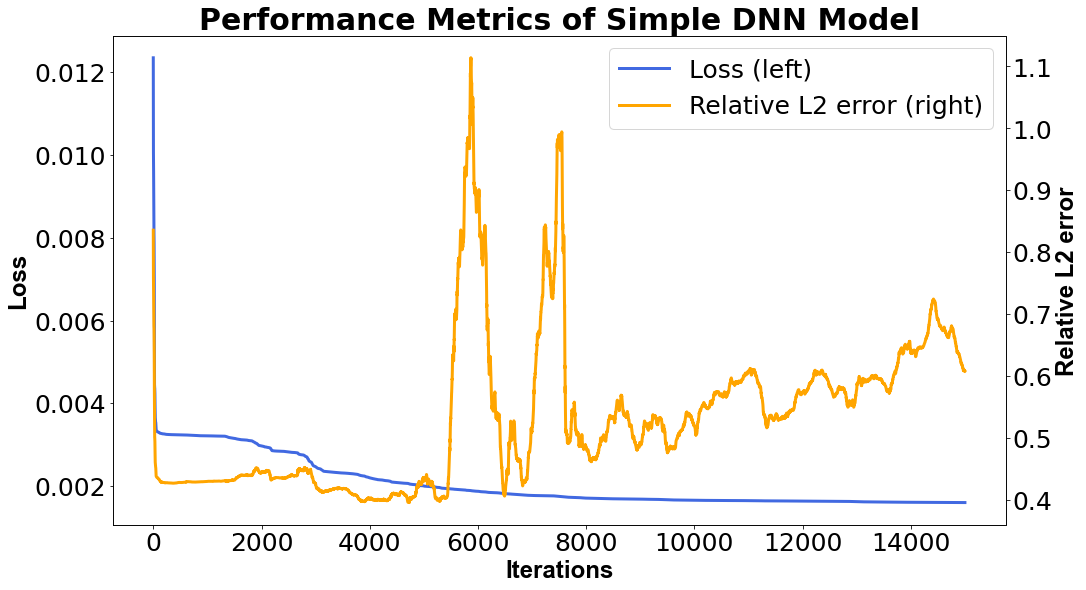

In [17]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Simple DNN Model", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)

# 전체 그리드 비교

In [18]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

MAE =  0.024710174669022485
MSE =  0.02278376113797189
RMSE =  0.15094290688194623
L2 relative error = 1.241722725486242
--------------------------------------------------


Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

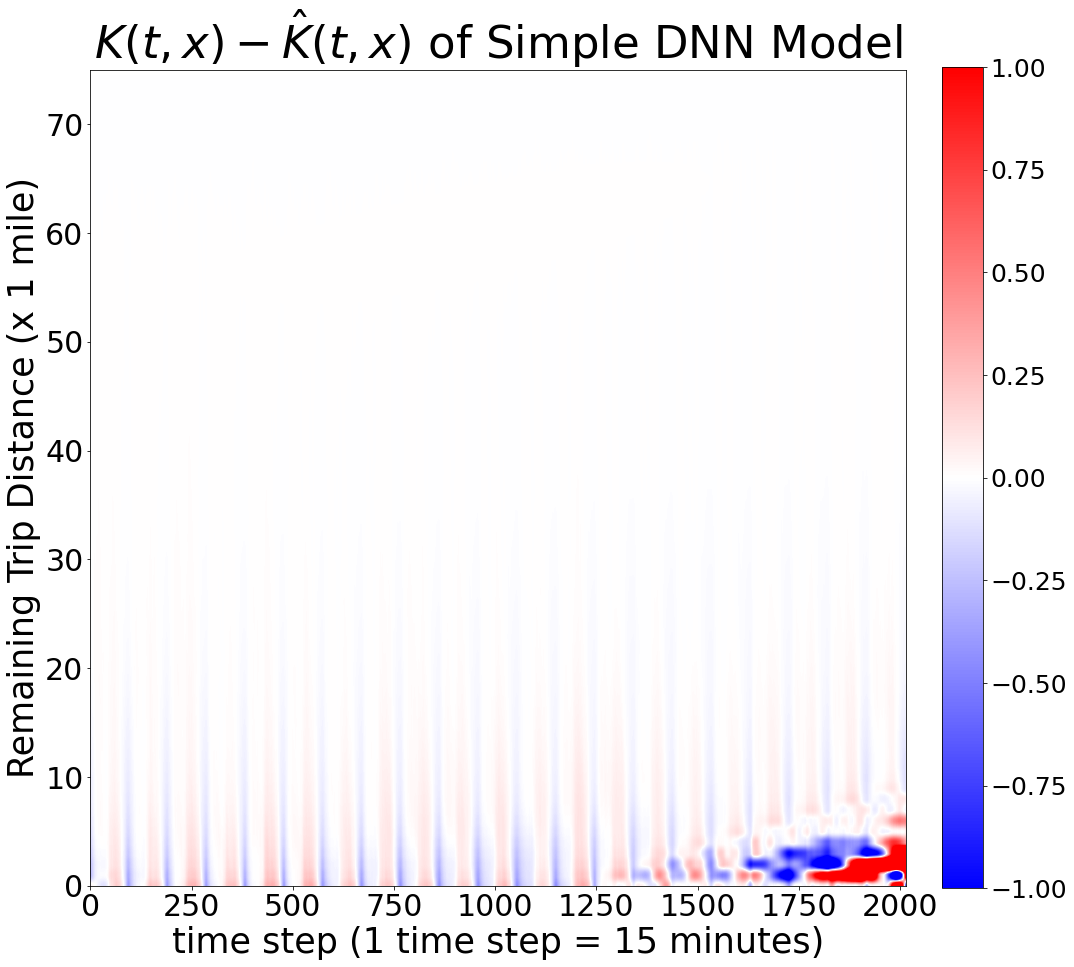

In [19]:
K_array = np.array(u_pred)
K_array = (usol - K_array)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Simple DNN Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

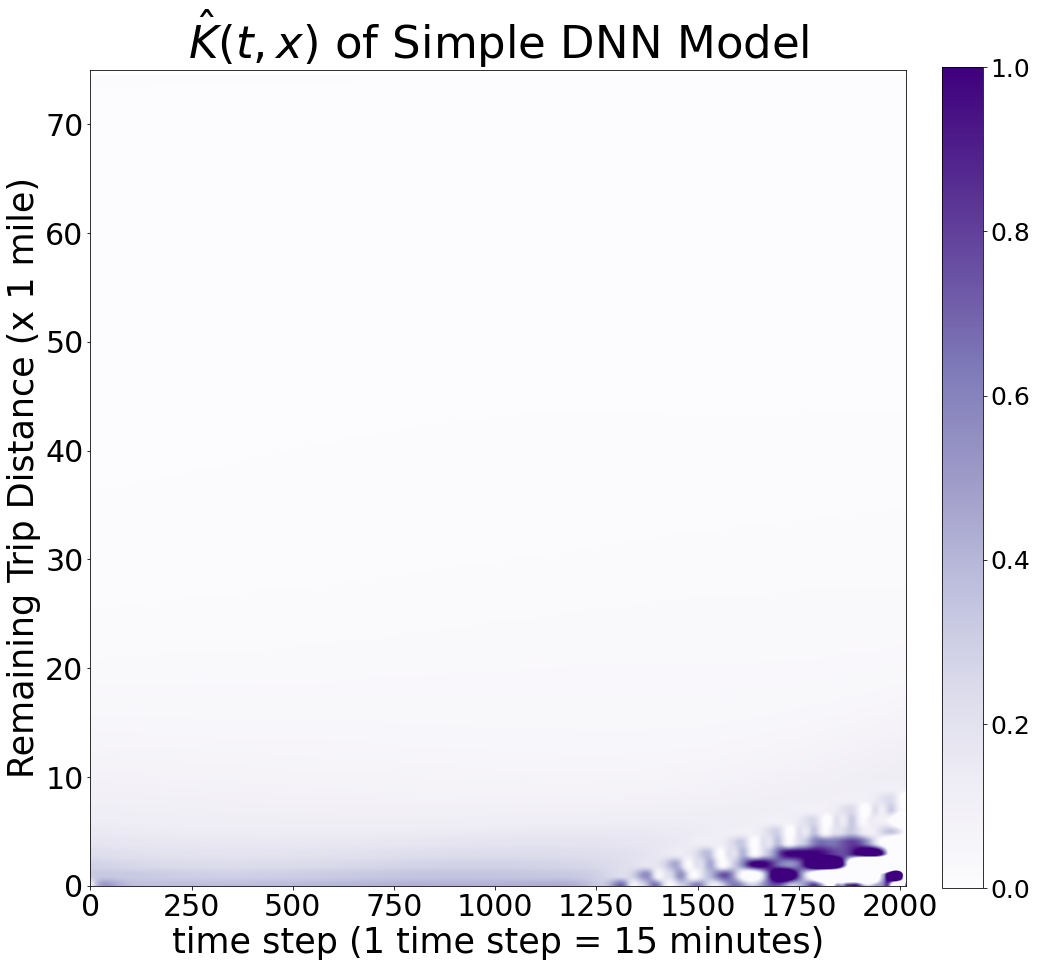

In [21]:
K_array = np.array(u_pred)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Simple DNN Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

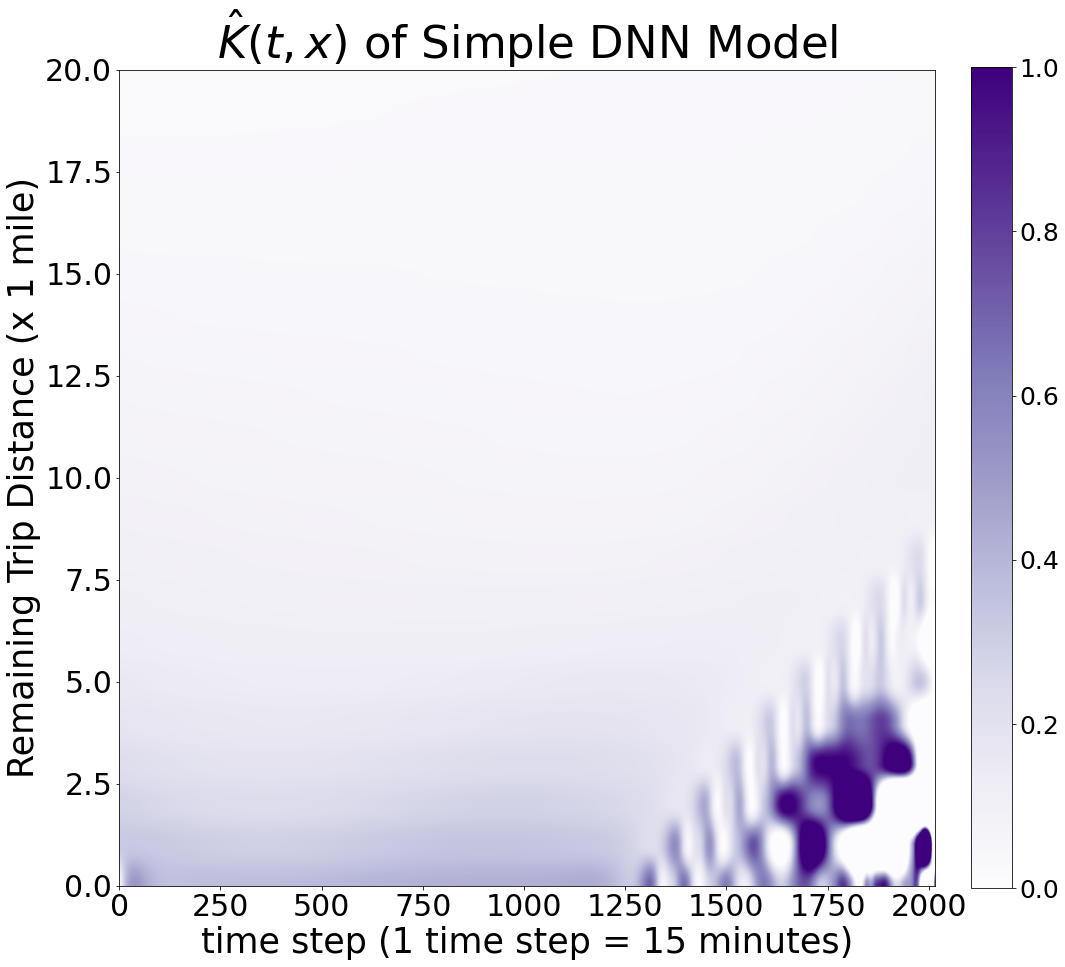

In [23]:
K_array = np.array(u_pred)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,20])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Simple DNN Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

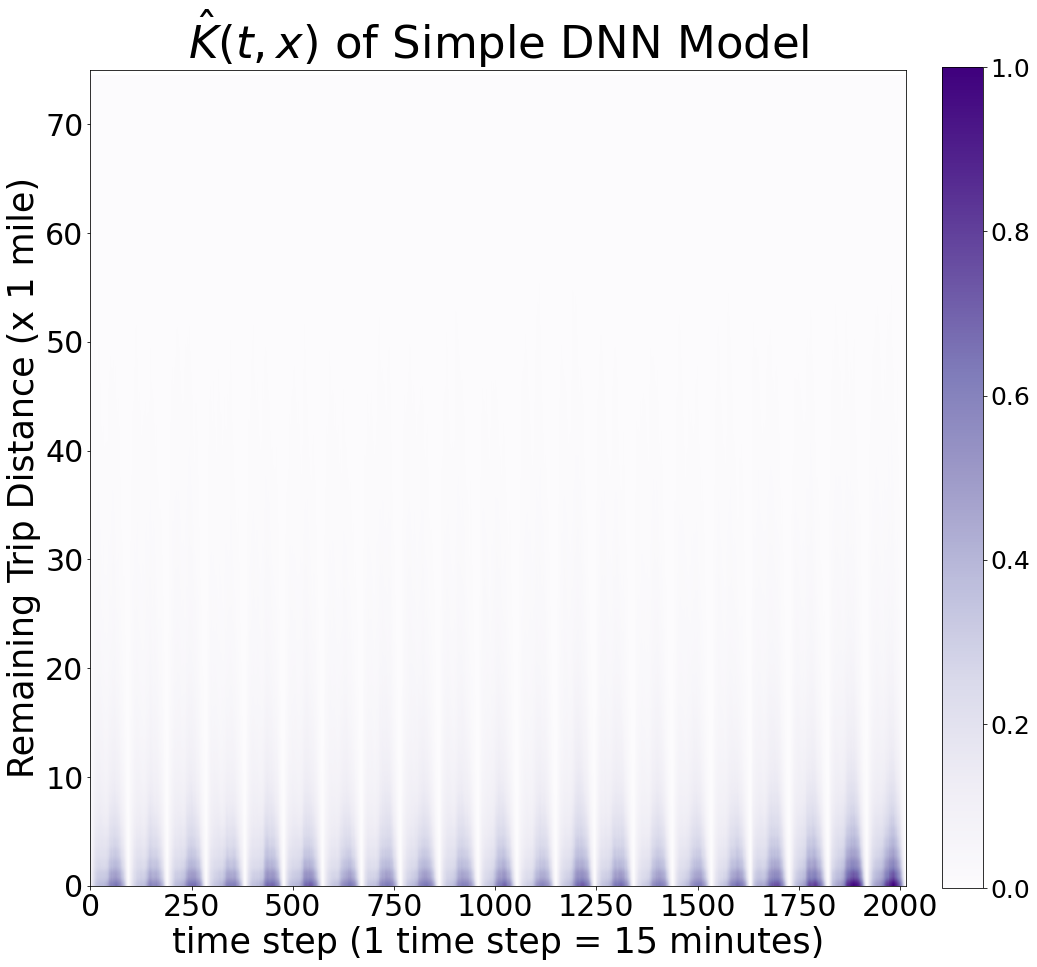

In [22]:
K_array = usol

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Simple DNN Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

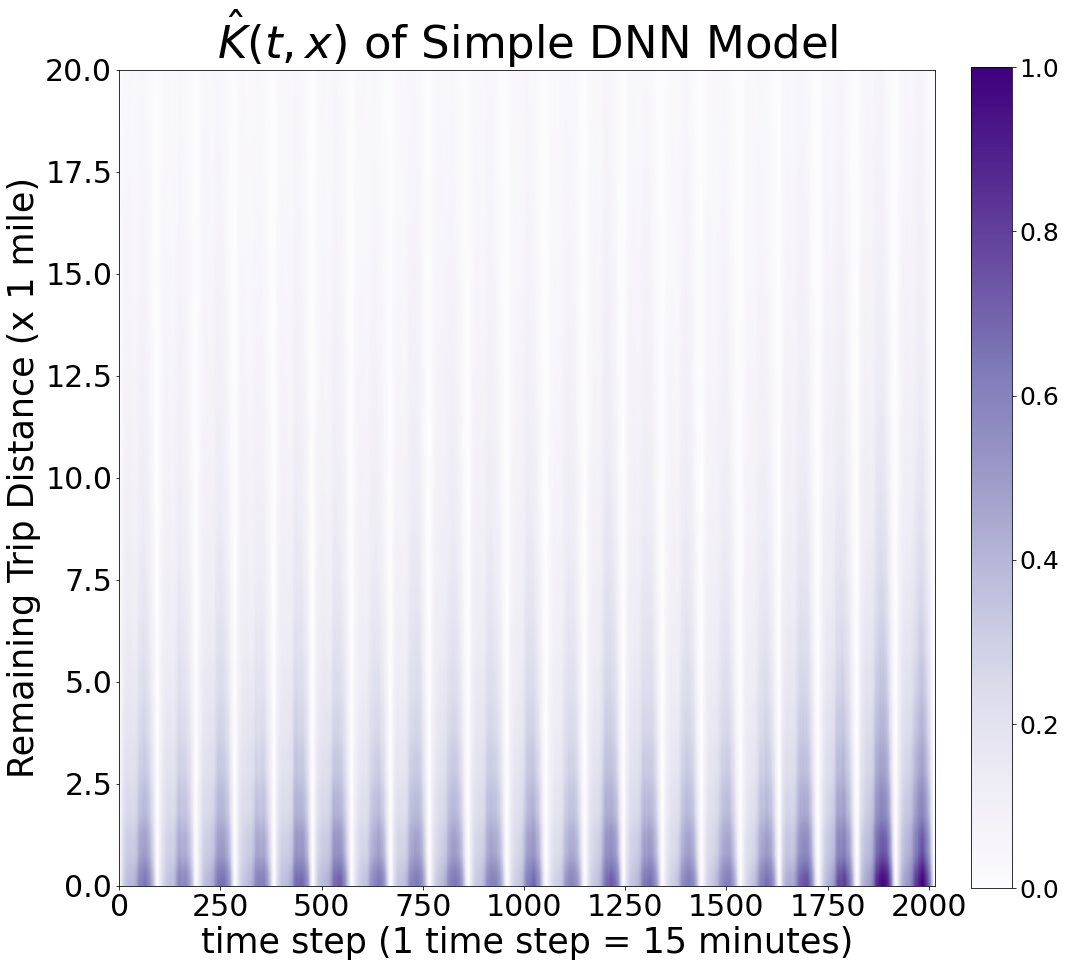

In [24]:
K_array = usol

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,20])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Simple DNN Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

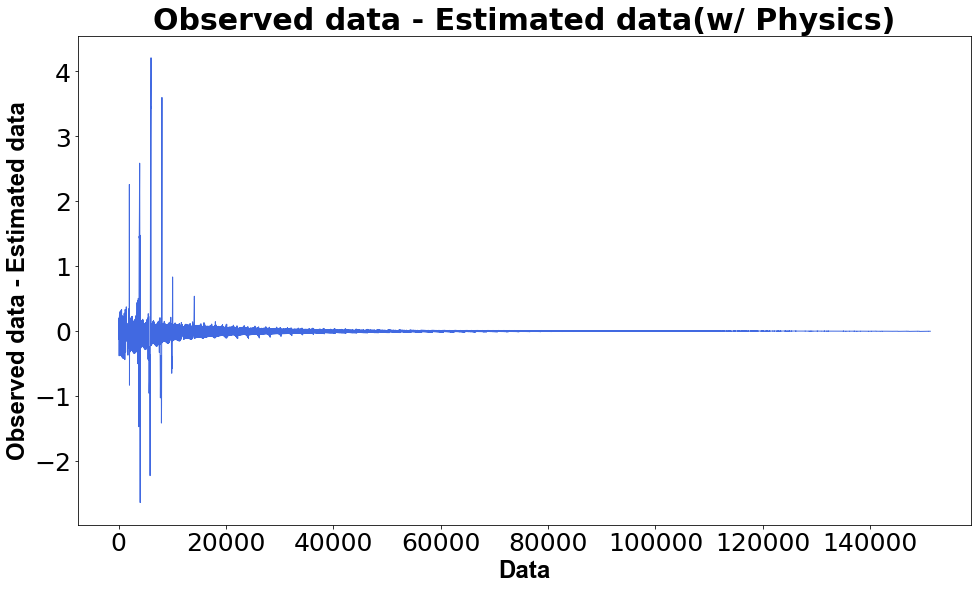

In [20]:
K_array = np.array(u_pred)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Simple DNN Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

K_array = usol

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Simple DNN Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data(w/ Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Estimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)